In [14]:
import os
import pydicom as dcm
from tools import *
from pydicom.uid import generate_uid
from datetime import datetime
import cv2
import matplotlib.pyplot as plt
import json
import csv

In [5]:
PATH = '/mnt/iDriveShare/Kayla/CBCT_images/kayla_extracted/' # Image Path
anon_RS_path = '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS/' # RS files of defaced CTs
og_RS_path = '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS_OG/' # RS files of original CTs

In [6]:
patient_list = ['19', '35', '54', '59', '81', '118', '272', '274', '437', '447', '448', '454', '459', '462', '469', '473', '474', '478', '483', '517', '518', '600', '625', '628', '633', '644', '651', '662', '673', '685', '694', '721', '723', '734', '738', '755', '770', '773', '786', '790', '820', '833', '838', '848', '892', '910', '937', '945', '946', '961', '965', '973', '1167', '1255', '1288', '1314', '1502', '1511', '1552', '1888', '1892', '1949', '1987', '2017', '2027', '2037', '2041', '2056', '2058', '2061']
print(len(patient_list), "patients.")

70 patients.


# OAR Auto-Segementation

### Load files

In [7]:
patients_same_date = ['517','518','118','478','673','838']

In [8]:
# Create the dict of files pointing to:
# - CT_1: the original CT scan
# - RS_1: the auto-segmented RS file of the original CT scan
# - RS_A: the auto-segmented RS file of the defaced CT scan

In [15]:
# METHOD 1 - Matching patients by UID (patients should be fed through Limbus and then reimported to the TPS to generate UID connections
dict_p = {}
dict_dates = {}
file_dict = {}
dict_uids = {}
for p in patient_list:
    CT_name = get_first_CT(os.path.join(PATH,p))
    CT_path = os.path.join(PATH,p,CT_name)
    CT_file = [f for f in os.listdir(CT_path) if 'CT' in f][0]
    
    UID = dcm.dcmread(PATH+p+'/'+CT_name+'/'+CT_file).FrameOfReferenceUID
    dict_uids[UID] = p
    
    dict_p[p] = CT_name
    file_dict[p] = {}
    file_dict[p]['CT']=os.path.join(CT_path,CT_file)
    date = datetime.strptime(CT_name[12:], "%d_%b_%Y").strftime("%Y%m%d")
    
    if date in dict_dates:
        print("PROBLEM - SAME DATE")
        print(dict_dates[date], p)
    dict_dates[date] = p


PROBLEM - SAME DATE
118 478
PROBLEM - SAME DATE
517 518
PROBLEM - SAME DATE
673 838


In [16]:
# Since patients were mapped to images with dates (just my own dict system), fix those with the same date
duplicate_dates = ['20191220','20211005','20190410']

In [17]:
#manually swap CT date for 1511, as took CT2 for anon
dict_p['1511'] = '20231002_CT_29_SEP_2023'
dict_dates['20230929'] = '1511'
dict_uids['1.2.246.352.221.461671203788179538416824606995535925934'] = '1511'
del dict_uids['1.2.246.352.221.52147478103674962812757250728644617873']

In [18]:

p_done =[]
for f in sorted([x for x in os.listdir(anon_RS_path) if 'RS' in x[0:2]]):# or 'limbus' in x[0:6]]):
    # print(f)
    # date = dcm.dcmread(anon_RS_path+f).StudyDate
    # print(
   
    uid = dcm.dcmread(anon_RS_path+f).FrameOfReferenceUID
    try:
        # print(f,date)
        # patient = dict_dates[date]
        patient = dict_uids[uid]
        if patient in p_done:
            print(patient, f)
            print(patient,file_dict[patient]['RS_A'])
        p_done.append(patient)
        file_dict[patient]['RS_A']=anon_RS_path+f
        # if date in duplicate_dates:
        #     print("anon",date,f)
    except Exception as e: 
        print("Error with RS",f,e)
        
    
    # print(date, dict_dates[str(date)])

for f in [x for x in os.listdir(og_RS_path) if 'RS' in x[0:2]]:#or 'limbus' in x[0:6]]:
    try:
        # print(p)
        # date = dcm.dcmread(og_RS_path+f).StudyDate
        uid = dcm.dcmread(og_RS_path+f).FrameOfReferenceUID
        # print(f,date)
        # patient = dict_dates[date]
        patient = dict_uids[uid]
        
        file_dict[patient]['RS_1']=og_RS_path+f
        # if date in duplicate_dates:
        #     print("og",date,f)    
    except Exception as e: 
        print("Error with OG",f,e)
            



Error with RS RS.1.2.826.0.1.3680043.8.498.10968679513518758955888124713111828897.dcm '1.2.246.352.221.55545278117470276949863706741079864465'
Error with RS RS.1.2.826.0.1.3680043.8.498.11543568290575043242173131748169888042.dcm '1.2.246.352.221.55545278117470276949863706741079864465'
Error with RS RS.1.2.826.0.1.3680043.8.498.18100706660915904812293193087294243279.dcm '1.2.246.352.221.47927005596030484265125225420560628392'
Error with RS RS.1.2.826.0.1.3680043.8.498.50225248025328293750190627338594216481.dcm '1.2.246.352.221.47927005596030484265125225420560628392'
Error with OG RS.1.2.826.0.1.3680043.8.498.96185752954431579966705789460282490567.dcm '1.2.246.352.221.47927005596030484265125225420560628392'
Error with OG RS.1.2.826.0.1.3680043.8.498.84255825403150160387184760556926745694.dcm '1.2.246.352.221.52147478103674962812757250728644617873'
Error with OG RS.1.2.826.0.1.3680043.8.498.48710965246676524075188275743971083814.dcm '1.2.246.352.221.55545278117470276949863706741079864465'

In [19]:
file_dict['600']['RS_A'] = '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS/RS.1.2.826.0.1.3680043.8.498.10968679513518758955888124713111828897.dcm'
file_dict['59']['RS_A'] = '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS/RS.1.2.826.0.1.3680043.8.498.18100706660915904812293193087294243279.dcm'
file_dict['517']['CT'] = '/mnt/iDriveShare/Kayla/CBCT_images/kayla_extracted/19/20180411_CT_09_APR_2018/CT.1.2.246.352.221.46157814662918147304165220025912152967.dcm'
# file_dict['517']['RS_A'] = '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS/.dcm'
# file_dict['517']['RS_1'] = '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/limbus_RS_OG/.dcm'
file_dict[p]['RS_1'] = '/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/limbus_1.8.1_1314.dcm'
file_dict[p]['RS_A'] = '/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/limbus_1.8.1_1314_A.dcm'

In [20]:
# Reran some, here are the new places:
ps_new = [f.split('_')[-2] for f in os.listdir('/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/rerun_LNs/') if '_A.dcm' in f]
print(ps_new)

['1949', '454', '945', '723', '973', '946', '2027', '2058', '738', '469', '685', '1255', '473', '838', '54', '518', '694', '651', '820', '1892', '892', '937', '2061', '2017', '961', '773', '2041', '478', '81', '633', '628', '474', '662', '734', '483', '35', '459', '721', '517', '2056', '1167', '1888', '910', '786', '965']


In [21]:
for p in ps_new:
    file_dict[p]['RS_1'] = '/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/rerun_LNs/limbus_1.8.1_'+p+'.dcm'
    file_dict[p]['RS_A'] = '/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/rerun_LNs/limbus_1.8.1_'+p+'_A.dcm'
    # p_path = '/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/changeuid/'+p
    # ct_path = os.path.join(p_path,os.listdir(p_path)[0])
    # file_dict[p]['CT'] = os.path.join(ct_path,os.listdir(ct_path)[0])


In [22]:
ps_new2 = [f.split('_')[-2] for f in os.listdir('/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/') if '_A.dcm' in f]
print(ps_new2)

['1949', '694', '833', '1511', '755', '1314', '673', '1987', '462']


In [23]:
for p in ps_new2:
    file_dict[p]['RS_1'] = '/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/limbus_1.8.1_'+p+'.dcm'
    file_dict[p]['RS_A'] = '/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/limbus_1.8.1_'+p+'_A.dcm'
    p_path = '/mnt/iDriveShare/Kayla/Defacing/CTs_for_limbus/changeuid/'+p
    

In [24]:
# Check that all patietns have all files
for p in patient_list:
    p = str(p)
    try:
        file_dict[p]['RS_A']
    except:
        print(p,"NO RS_A")

    try:
        file_dict[p]['RS_1']
    except:
        print(p,"NO RS_1")

    try:
        file_dict[p]['CT']
    except:
        print(p,"NO CT")

In [25]:
with open('/data/kayla/deface_file_dict.json', "w") as outfile:
    json.dump(file_dict,outfile)

### Dice Score Functions

In [26]:

def calculate_dice_score_3d(volume1, volume2):
    assert volume1.shape == volume2.shape, "Volumes must have the same shape"

    intersection = np.logical_and(volume1, volume2).sum()
    union = volume1.sum() + volume2.sum()

    dice_score = 2 * intersection / union

    return dice_score


In [27]:
def xyz_to_image_coords_3D(contour,spacing,origin):
    image_coords = []
    
    # Pre-compute reciprocals to avoid division in loops
    inv_spacing = [1.0/s for s in spacing]
    
    for slice_data in contour:
        # Convert to numpy array and reshape for vectorized operations
        slice_array = np.array(slice_data).reshape(-1, 3)
        
        # Vectorized coordinate transformation
        transformed = (slice_array - origin) * inv_spacing
        
        # Flatten back to original format
        image_coords.append(transformed.flatten().tolist())
        
    return image_coords
        

In [28]:
def get_binary_volume(img_coords, max_z=0,rows=512, cols=512):
    if max_z == 0:
        #
        all_z_coords = []
        for c_slice in img_coords:
            all_z_coords.extend(c_slice[2::3])
        max_z = int(max(all_z_coords))
        
    volume_shape = (max_z + 1, rows, cols)
    volume_binary = np.zeros(volume_shape, dtype=np.uint8)
    
    for c_slice in img_coords:
        z = int(c_slice[2])
        
        # Extract X, Y coordinates
        X = np.array(c_slice[0::3], dtype=np.int32)
        Y = np.array(c_slice[1::3], dtype=np.int32)
        
        # Create contour points
        if len(X) > 2:  # Need at least 3 points for a polygon
            contour_points = np.column_stack((X, Y))
            
            cv2.fillPoly(volume_binary[z], [contour_points], 1)
    
    return volume_binary


In [29]:
def calculate_dice_score_3d_optimized(binary_truth, binary_test):
  
    truth_flat = binary_truth.flatten()
    test_flat = binary_test.flatten()
    

    intersection = np.sum(truth_flat * test_flat)
    sum_volumes = np.sum(truth_flat) + np.sum(test_flat)
    
    if sum_volumes == 0:
        return 1.0 
    
    return 2.0 * intersection / sum_volumes

In [30]:
def get_DSC_single(contour_truth, contour_test,spacing,origin):

    if not contour_truth or not contour_test:
        return 0.0
    
    start_z = min(contour_truth[0][2], contour_test[0][2])
    adjusted_origin = [origin[0], origin[1], start_z]
    

    img_coords_truth = xyz_to_image_coords_3D(contour_truth, spacing, adjusted_origin)
    img_coords_test = xyz_to_image_coords_3D(contour_test, spacing, adjusted_origin)
    
    # Calculate max_z
    all_z_truth = [int(s[2]) for s in img_coords_truth if len(s) > 2]
    all_z_test = [int(s[2]) for s in img_coords_test if len(s) > 2]
    
    if not all_z_truth or not all_z_test:
        return 0.0
        
    max_z = max(max(all_z_truth), max(all_z_test))
    

    binary_truth = get_binary_volume(img_coords_truth, max_z)
    binary_test = get_binary_volume(img_coords_test, max_z)
    

    score = calculate_dice_score_3d(binary_truth, binary_test)
    
    return score

In [31]:
def get_DSC_all(RS_truth, RS_test,CT_dcm):
    # ignore body
      
    # Get ROI names (excluding BODY)
    names_truth = [n for n in find_ROI_names(RS_truth) if n != 'BODY']
    names_test = [n for n in find_ROI_names(RS_test) if n != 'BODY']
    
    if not names_truth or not names_test:
        return {}
    
    # print(f"Truth ROIs: {names_truth}")
    # print(f"Test ROIs: {names_test}")
    
    # Get all contours at once
    cont_truth, zs_truth = get_all_ROI_contours(names_truth, RS_truth)
    cont_test, zs_test = get_all_ROI_contours(names_test, RS_test)

    # Extract spacing and origin 
    origin = CT_dcm.ImagePositionPatient
    spacing = [CT_dcm.PixelSpacing[0], CT_dcm.PixelSpacing[1], CT_dcm.SliceThickness]
    
    scores = {}
    unmatched_names = []
    
    # Process only matching names
    for name in names_test:
        if name not in names_truth:
            print(f"WARNING: No ground truth for contour named '{name}'")
            continue
        
        if name not in cont_truth or name not in cont_test:
            print(f"WARNING: Missing contour data for '{name}'")
            continue
            
        try:
            score = get_DSC_single(cont_truth[name], cont_test[name], spacing, origin)
            scores[name] = score
            
        except Exception as e:
            print(f"ERROR processing '{name}': {e}")
    
    # Find unmatched truth names
    unmatched_names = [name for name in names_truth if name not in scores]
    if unmatched_names:
        print(f"Names in truth not matched: {unmatched_names}")
    
    return scores




### Calculate Dice Scores

In [32]:
with open('/data/kayla/deface_file_dict.json', "r") as outfile:
    file_dict = json.load(outfile)

In [33]:
dict_DSC = {}



In [34]:

for p in patient_list:
    print(p)
    RS_A = dcm.dcmread(file_dict[p]['RS_A'])
    RS_1 = dcm.dcmread(file_dict[p]['RS_1'])
    CT = dcm.dcmread(file_dict[p]['CT'])

    dict_DSC[p] = get_DSC_all(RS_1, RS_A, CT)

19
Names in truth not matched: ['Lens_R', 'Lens_L']
35
Names in truth not matched: ['Lens_L', 'Lens_R']
54
Names in truth not matched: ['Lens_R']
59
Names in truth not matched: ['Lens_R', 'Lens_L']
81
Names in truth not matched: ['Lens_L', 'Lens_R']
118
Names in truth not matched: ['Lens_R', 'Lens_L']
272
Names in truth not matched: ['Lens_L', 'Lens_R']
274
Names in truth not matched: ['Lens_R']
437
Names in truth not matched: ['Lens_R', 'Lens_L']
447
Names in truth not matched: ['Lens_L', 'Lens_R']
448
Names in truth not matched: ['Lens_R', 'Lens_L']
454
Names in truth not matched: ['Lens_L', 'Lens_R']
459
Names in truth not matched: ['Lens_L']
462
469
Names in truth not matched: ['Lens_L', 'Lens_R']
473
Names in truth not matched: ['Lens_L']
474
Names in truth not matched: ['Lens_L', 'Lens_R']
478
Names in truth not matched: ['Lens_L']
483
Names in truth not matched: ['Lens_R']
517
Names in truth not matched: ['Lens_L']
518
Names in truth not matched: ['Lens_R']
600
Names in truth no

In [35]:
print((len(dict_DSC)),"patients processed.")
if len(dict_DSC) != len(patient_list):
    print("The following patients were not processed:",[p for p in patient_list if p not in dict_DSC])

70 patients processed.


In [36]:
with open("results/DSC_scores_final.json", "w") as outfile: 
    json.dump(dict_DSC, outfile)

### Analysis & Graphing

In [37]:
with open("results/DSC_scores_final.json", "r") as outfile: 
    dict_DSC = json.load(outfile)

In [38]:
# Check for patients whose dice scores != 1 (except those we know are not)
for p in sorted(dict_DSC.keys(),key=int):
    for o in dict_DSC[p]:
        if dict_DSC[p][o] < 1 and o not in ['Eye_L','Eye_R','OpticChiasm','OpticNrv_L','OpticNrv_R', 'Brain','Cornea_L','Cornea_R','Lens_L','Lens_R']:
            print(p,o, dict_DSC2[p][o])


In [39]:
organs = sorted({organ for scores in dict_DSC.values() for organ in scores})

# Write to CSV
with open('dice_scores2.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    # Write header
    writer.writerow(['Patient_ID'] + organs)
    
    # Write each patient's scores
    for patient_id, scores in dict_DSC.items():
        row = [patient_id] + [scores.get(organ, '') for organ in organs]
        writer.writerow(row)

In [40]:
done = 0
ps_done = []
organs = list(dict_DSC[patient_list[0]].keys())
dict_organs = {}

p_error_dict = {}
p_not_one= {}
p_all = {}

for o in organs:
    dict_organs[o] = []

    for p in patient_list:
        p = str(p)
        if p not in dict_DSC:
            print("Patient", p, "not in DICT DSC") 
        if p not in p_all:
            p_all[p] = []

        try:
            dict_organs[o].append(dict_DSC[p][o])
            if o not in ['Brain','Cornea_L','Cornea_R','Eye_L','Eye_R','OpticChiasm','OpticNrv_R','OpticNrv_L'] and dict_DSC[p][o] != 1:
               

                print(p,o,"NOT ONE",dict_DSC[p][o])
                print(file_dict[p])
                print("*****")
                if p not in p_not_one:
                   p_not_one[p]= []
                p_not_one[p].append(o+" "+str(dict_DSC[p][o]))
                p_all[p].append(o)
        except Exception as e:
            if p not in p_error_dict:
                p_error_dict[p] = []
            p_error_dict[p].append(e)


In [41]:
organs_1 = find_ROI_names(RS_1)
print(organs_1)
print(len(organs_1))

['Bone_Hyoid', 'Bone_Mandible', 'BrachialPlex_L', 'BrachialPlex_R', 'Brain', 'Brainstem', 'Cavity_Oral', 'Clavicle_L', 'Clavicle_R', 'Cochlea_L', 'Cochlea_R', 'Cornea_L', 'Cornea_R', 'Esophagus', 'Eye_L', 'Eye_R', 'Glnd_Submand_L', 'Glnd_Submand_R', 'Glnd_Thyroid', 'Hippocampus_L', 'Hippocampus_R', 'Larynx', 'Lens_L', 'Lens_R', 'Lips', 'LN_Neck_2347AB_L', 'LN_Neck_2347AB_R', 'LN_Neck_IA', 'LN_Neck_IB_L', 'LN_Neck_IB_R', 'LN_Neck_L', 'LN_Neck_R', 'LN_Neck_V_L', 'LN_Neck_V_R', 'LN_Neck_VI', 'Lung_L', 'Lung_R', 'OpticChiasm', 'OpticNrv_L', 'OpticNrv_R', 'Parotid_L', 'Parotid_R', 'Pharynx', 'Pituitary', 'SpinalCanal', 'SpinalCord~']
46


In [42]:
organ_classification = {}
count_below = 0
count_cropped = 0
count_overlapping = 0
for o in organs_1:
    if 'Eye' in o or 'Lens' in o or 'Cornea' in o:
        organ_classification[o] = 'Cropped'
        count_cropped+=1
    elif 'Brain' in o or 'Optic' in o or 'Pituitary' in o or 'Hippo' in o:
        organ_classification[o] ='Overlapping'
        count_overlapping+=1
    else:
        organ_classification[o] = 'Below'
        count_below+=1
print(count_cropped, "cropped")
print(count_overlapping, "overlapping slices")
print(count_below, "below")


6 cropped
8 overlapping slices
32 below


In [43]:
organ_classification

{'Bone_Hyoid': 'Below',
 'Bone_Mandible': 'Below',
 'BrachialPlex_L': 'Below',
 'BrachialPlex_R': 'Below',
 'Brain': 'Overlapping',
 'Brainstem': 'Overlapping',
 'Cavity_Oral': 'Below',
 'Clavicle_L': 'Below',
 'Clavicle_R': 'Below',
 'Cochlea_L': 'Below',
 'Cochlea_R': 'Below',
 'Cornea_L': 'Cropped',
 'Cornea_R': 'Cropped',
 'Esophagus': 'Below',
 'Eye_L': 'Cropped',
 'Eye_R': 'Cropped',
 'Glnd_Submand_L': 'Below',
 'Glnd_Submand_R': 'Below',
 'Glnd_Thyroid': 'Below',
 'Hippocampus_L': 'Overlapping',
 'Hippocampus_R': 'Overlapping',
 'Larynx': 'Below',
 'Lens_L': 'Cropped',
 'Lens_R': 'Cropped',
 'Lips': 'Below',
 'LN_Neck_2347AB_L': 'Below',
 'LN_Neck_2347AB_R': 'Below',
 'LN_Neck_IA': 'Below',
 'LN_Neck_IB_L': 'Below',
 'LN_Neck_IB_R': 'Below',
 'LN_Neck_L': 'Below',
 'LN_Neck_R': 'Below',
 'LN_Neck_V_L': 'Below',
 'LN_Neck_V_R': 'Below',
 'LN_Neck_VI': 'Below',
 'Lung_L': 'Below',
 'Lung_R': 'Below',
 'OpticChiasm': 'Overlapping',
 'OpticNrv_L': 'Overlapping',
 'OpticNrv_R': 'Over

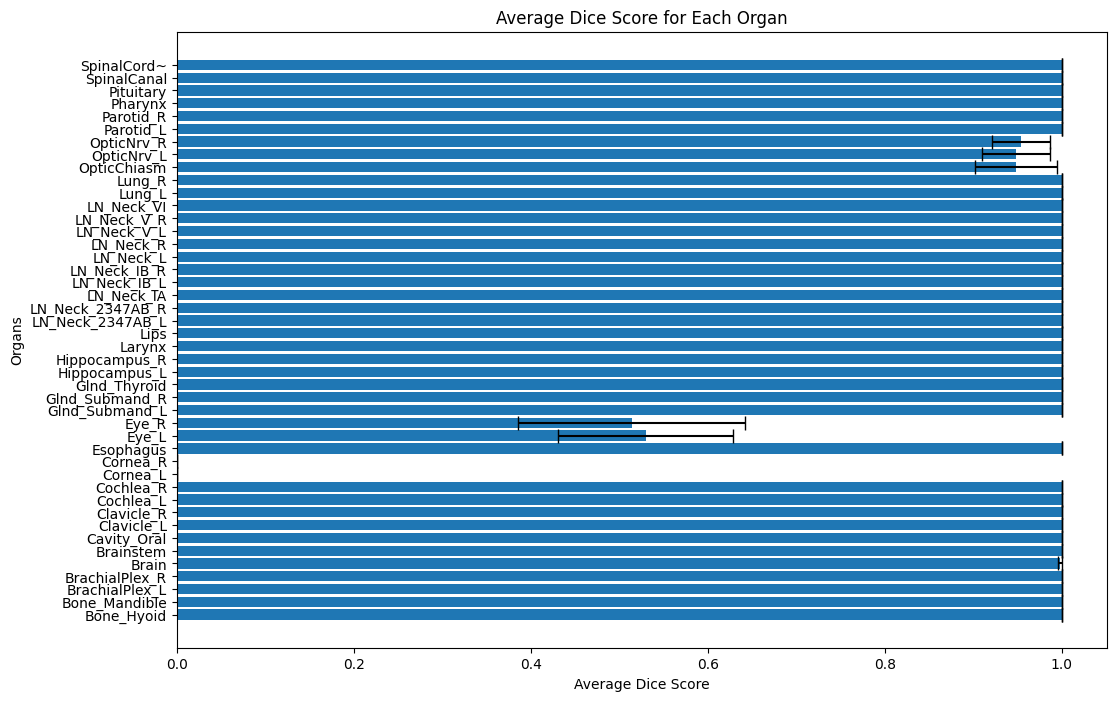

In [44]:
organ_means = {organ: np.mean(scores) for organ, scores in dict_organs.items()}
organ_stddevs = {organ: np.std(scores) for organ, scores in dict_organs.items()}

# Plotting
organs = list(organ_means.keys())
means = list(organ_means.values())
stddevs = list(organ_stddevs.values())

plt.figure(figsize=(12, 8))
plt.barh(organs, means, xerr=stddevs, capsize=5)
plt.xlabel('Average Dice Score')
plt.ylabel('Organs')
plt.title('Average Dice Score for Each Organ')
plt.show()

In [45]:
len(organs)

44

In [46]:
for o in organ_means:
    print(o,":",organ_means[o],'+/-',organ_stddevs[o])

Bone_Hyoid : 1.0 +/- 0.0
Bone_Mandible : 1.0 +/- 0.0
BrachialPlex_L : 1.0 +/- 0.0
BrachialPlex_R : 1.0 +/- 0.0
Brain : 0.9985585427932757 +/- 0.0022806754396125727
Brainstem : 1.0 +/- 0.0
Cavity_Oral : 1.0 +/- 0.0
Clavicle_L : 1.0 +/- 0.0
Clavicle_R : 1.0 +/- 0.0
Cochlea_L : 1.0 +/- 0.0
Cochlea_R : 1.0 +/- 0.0
Cornea_L : 0.0 +/- 0.0
Cornea_R : 0.0 +/- 0.0
Esophagus : 1.0 +/- 0.0
Eye_L : 0.5299028516303327 +/- 0.09886915308737354
Eye_R : 0.5139005114334373 +/- 0.12794466633796314
Glnd_Submand_L : 1.0 +/- 0.0
Glnd_Submand_R : 1.0 +/- 0.0
Glnd_Thyroid : 1.0 +/- 0.0
Hippocampus_L : 1.0 +/- 0.0
Hippocampus_R : 1.0 +/- 0.0
Larynx : 1.0 +/- 0.0
Lips : 1.0 +/- 0.0
LN_Neck_2347AB_L : 1.0 +/- 0.0
LN_Neck_2347AB_R : 1.0 +/- 0.0
LN_Neck_IA : 1.0 +/- 0.0
LN_Neck_IB_L : 1.0 +/- 0.0
LN_Neck_IB_R : 1.0 +/- 0.0
LN_Neck_L : 1.0 +/- 0.0
LN_Neck_R : 1.0 +/- 0.0
LN_Neck_V_L : 1.0 +/- 0.0
LN_Neck_V_R : 1.0 +/- 0.0
LN_Neck_VI : 1.0 +/- 0.0
Lung_L : 1.0 +/- 0.0
Lung_R : 1.0 +/- 0.0
OpticChiasm : 0.94861867186

In [84]:
# dcm.dcmread(og_RS_path+'RS.1.2.826.0.1.3680043.8.498.92111241876127827867792484102989368007.dcm')

In [85]:
plt.rcParams.update({'font.size': 24})

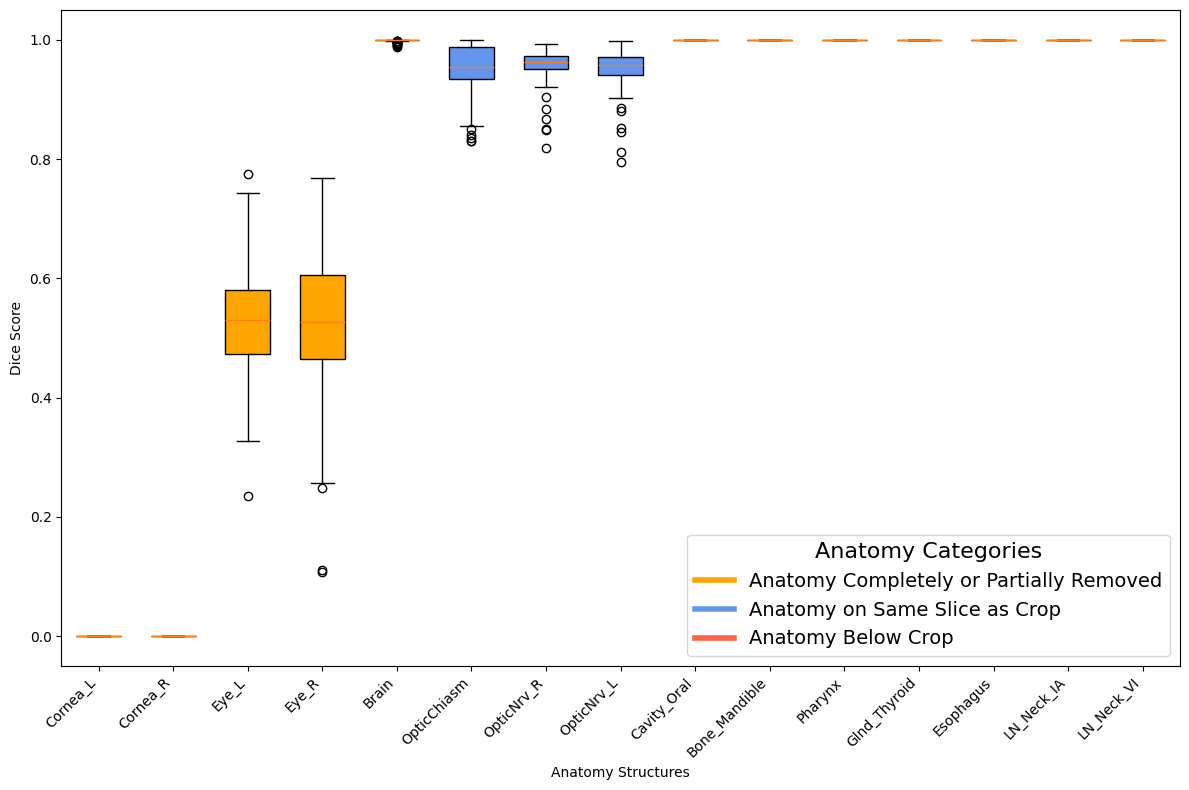

In [47]:
selected_organs = [ 'Cornea_L', 'Cornea_R', 'Eye_L', 'Eye_R', 'Brain', 'OpticChiasm', 'OpticNrv_R', 'OpticNrv_L', 'Cavity_Oral', 'Bone_Mandible','Pharynx', 'Glnd_Thyroid','Esophagus', 'LN_Neck_IA','LN_Neck_VI'] # Filter the data 
filtered_data = {organ: dict_organs[organ] for organ in selected_organs}
labels = list(filtered_data.keys()) 
data = list(filtered_data.values()) 
colors = ['orange'] * 4 + ['cornflowerblue'] * 4 + ['tomato'] * 7 # Define colors for the groups 
fig, ax = plt.subplots(figsize=(12, 8)) # Create box plots 
for i in range(len(labels)): 
    ax.boxplot(filtered_data[labels[i]], positions=[i], widths=0.6, patch_artist=True, boxprops=dict(facecolor=colors[i])) 
    # Add some text for labels, title and custom x-axis tick labels, etc. 
ax.set_ylabel('Dice Score') 
ax.set_xlabel('Anatomy Structures') 
ax.set_xticks(np.arange(len(labels))) 
ax.set_xticklabels(labels, rotation=45, ha='right') 
# ax.invert_yaxis() # Invert y axis to have the first item at the top # Add legend 
legend_labels = ['Anatomy Completely or Partially Removed', 'Anatomy on Same Slice as Crop', 'Anatomy Below Crop'] 
handles = [plt.Line2D([0], [0], color=c, lw=4) 
           for c in ['orange', 'cornflowerblue', 'tomato']] 
ax.legend(handles, legend_labels, fontsize=14, title='Anatomy Categories', title_fontsize='16') 
fig.tight_layout() 
plt.show()

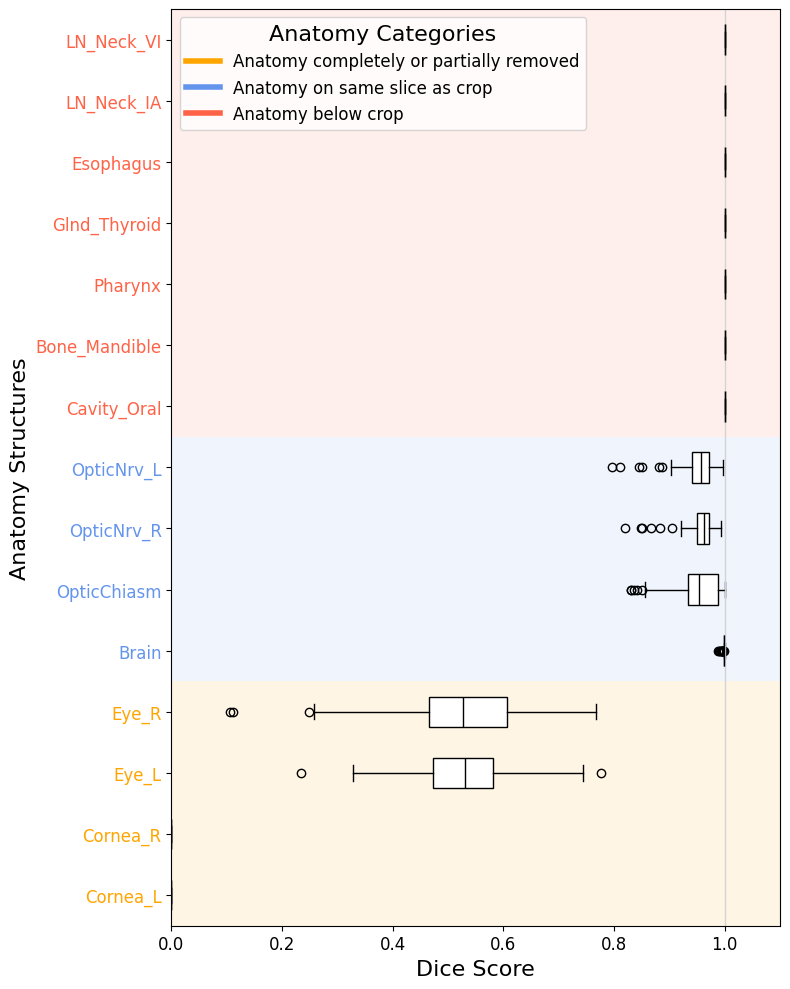

In [48]:
fig, ax = plt.subplots(figsize=(8, 10))  # Taller layout for vertical organ labels

# Create background shading for each category
for i in range(len(colors)):
    ax.axhspan(i + 0.5, i + 1.5, facecolor=colors[i], alpha=0.1)

# Create horizontal box plots
boxplots = ax.boxplot(data, vert=False, patch_artist=True)

# Customize box colors
for patch in boxplots['boxes']:
    patch.set_facecolor('white')
    patch.set_edgecolor('black')

# Set whiskers, caps, medians, fliers to black
for partname in ('whiskers', 'caps', 'medians', 'fliers'):
    plt.setp(boxplots[partname], color='black')

# Axis labels
ax.set_xlabel('Dice Score', fontsize=16)
ax.set_ylabel('Anatomy Structures', fontsize=16)
ax.set_yticks(np.arange(1, len(labels) + 1))
ax.set_yticklabels(labels, fontsize=12)

# Highlight y-axis labels
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color(colors[i])

# Add reference line at Dice = 1
ax.axvline(x=1, color='lightgray', linestyle='-', linewidth=1)

# Adjust x-axis range
ax.set_xlim(0, 1.1)
ax.set_xticks(np.arange(0, 1.1, 0.2))
ax.set_xticklabels([f'{tick:.1f}' for tick in np.arange(0, 1.1, 0.2)], fontsize=12)

# Add legend
legend_labels = ['Anatomy completely or partially removed', 'Anatomy on same slice as crop', 'Anatomy below crop']
handles = [plt.Line2D([0], [0], color=c, lw=4) for c in ['orange', 'cornflowerblue', 'tomato']]
ax.legend(handles, legend_labels, fontsize=12, title='Anatomy Categories', title_fontsize='16')

fig.tight_layout()
plt.show()


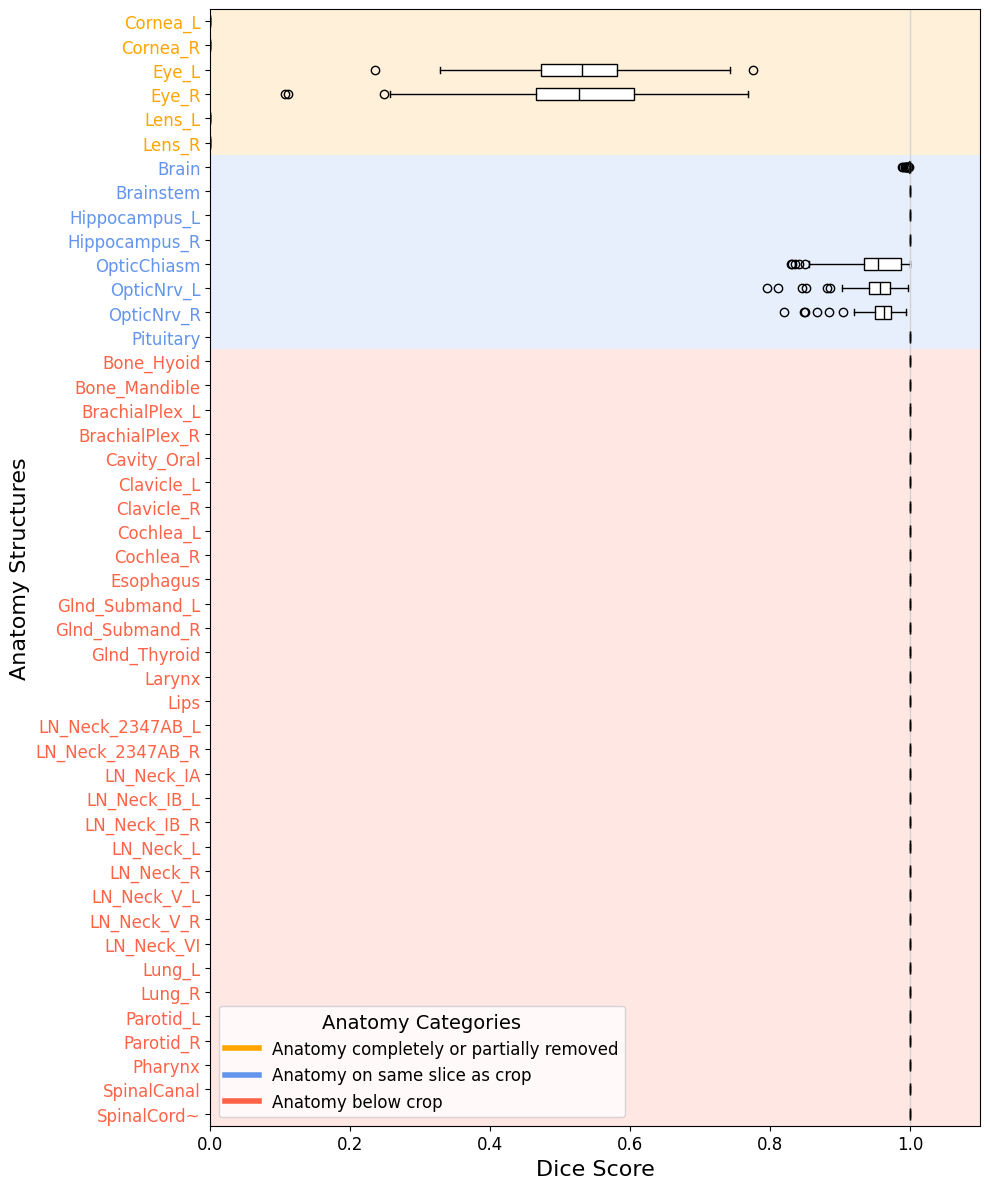

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your dict_organs data and organs_1 list
# Replace these with your actual data variables

# Define color mapping for each category
category_colors = {
    'Cropped': 'orange',
    'Overlapping': 'cornflowerblue', 
    'Below': 'tomato'
}

# Create organ classification (assuming organs_1 is your list of all organs)
organ_classification = {}
for o in organs_1:  # Replace with your actual organs list
    if 'Eye' in o or 'Lens' in o or 'Cornea' in o:
        organ_classification[o] = 'Cropped'
    elif 'Brain' in o or 'Optic' in o or 'Pituitary' in o or 'Hippo' in o:
        organ_classification[o] = 'Overlapping'
    else:
        organ_classification[o] = 'Below'

# Group organs by classification and maintain order
cropped_organs = [o for o in organs_1 if organ_classification[o] == 'Cropped']
overlapping_organs = [o for o in organs_1 if organ_classification[o] == 'Overlapping']
below_organs = [o for o in organs_1 if organ_classification[o] == 'Below']

# Combine in desired order
ordered_organs = cropped_organs + overlapping_organs + below_organs

# since all 0
dict_organs['Lens_L'] = dict_organs['Cornea_L']
dict_organs['Lens_R'] = dict_organs['Cornea_R']

# Filter data for ordered organs
filtered_data = [dict_organs[organ] for organ in ordered_organs]

# Convert organ names to display names if you have a mapping dictionary
# labels = [selected_organs_dict.get(organ, organ) for organ in ordered_organs]
labels = ordered_organs  # Use this if no display name mapping

# Create colors list for each organ
colors = [category_colors[organ_classification[organ]] for organ in ordered_organs]

# Create the horizontal box plot
fig, ax = plt.subplots(figsize=(10, 12))

# Create horizontal box plots
boxplots = ax.boxplot(filtered_data, vert=False, patch_artist=True)

# Customize box plot colors
for i, patch in enumerate(boxplots['boxes']):
    patch.set_facecolor('white')
    patch.set_edgecolor('black')
    
    # Add background shading for each category
    ax.axhspan(i + 0.5, i + 1.5, facecolor=colors[i], alpha=0.15)

# Set the whiskers, caps, medians, and fliers to black
for partname in ('whiskers', 'caps', 'medians', 'fliers'):
    plt.setp(boxplots[partname], color='black')

# Customize axes
ax.set_xlabel('Dice Score', fontsize=16)
ax.set_ylabel('Anatomy Structures', fontsize=16)
ax.set_yticks(np.arange(1, len(labels) + 1))
ax.set_yticklabels(labels, fontsize=12)

# Color the y-axis labels according to their category
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color(colors[i])

# Add vertical reference line at 1.0
ax.axvline(x=1, color='lightgray', linestyle='-', linewidth=1)

# Set x-axis limits and ticks
ax.set_xlim(0, 1.1)
ax.set_xticks(np.arange(0, 1.1, 0.2))
ax.set_xticklabels([f'{tick:.1f}' for tick in np.arange(0, 1.1, 0.2)], fontsize=12)

# Add legend
legend_labels = ['Anatomy completely or partially removed', 
                'Anatomy on same slice as crop', 
                'Anatomy below crop']
legend_colors = ['orange', 'cornflowerblue', 'tomato']
handles = [plt.Line2D([0], [0], color=c, lw=4) for c in legend_colors]
ax.legend(handles, legend_labels, fontsize=12, title='Anatomy Categories', title_fontsize=14)

# Invert y-axis to have first category at top
ax.invert_yaxis()

fig.tight_layout()
plt.show()

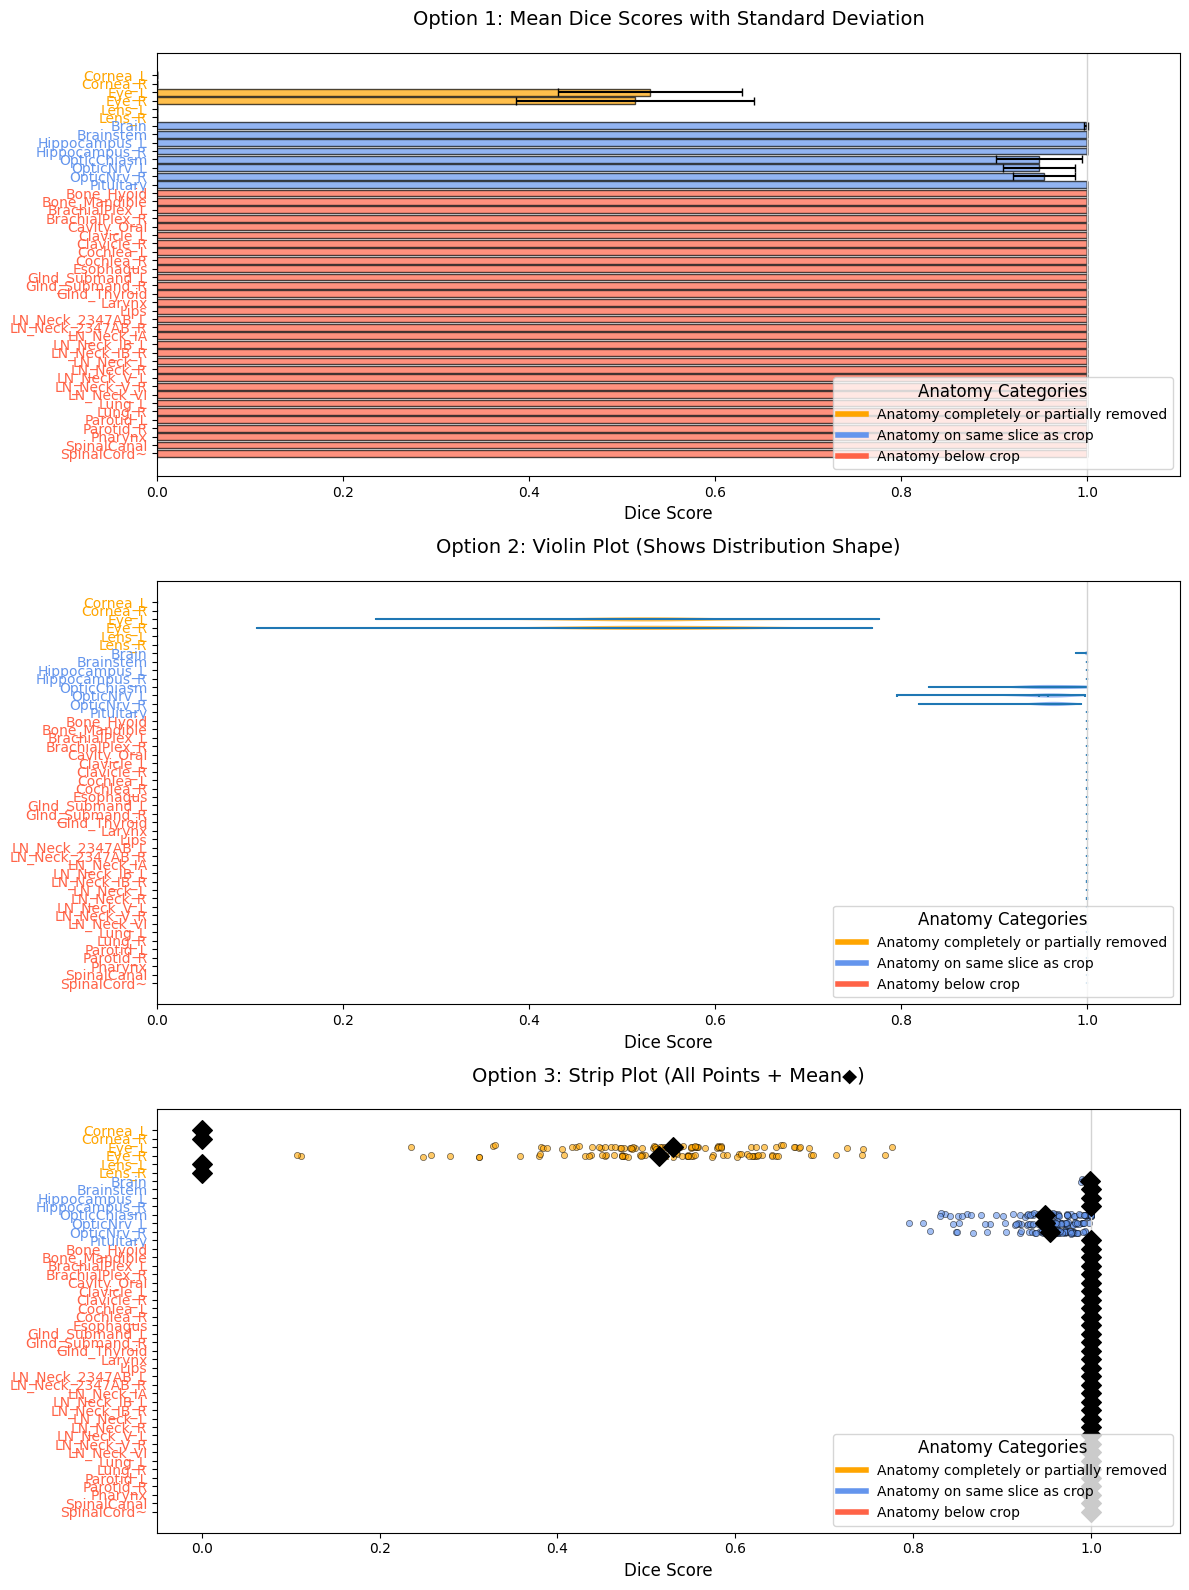

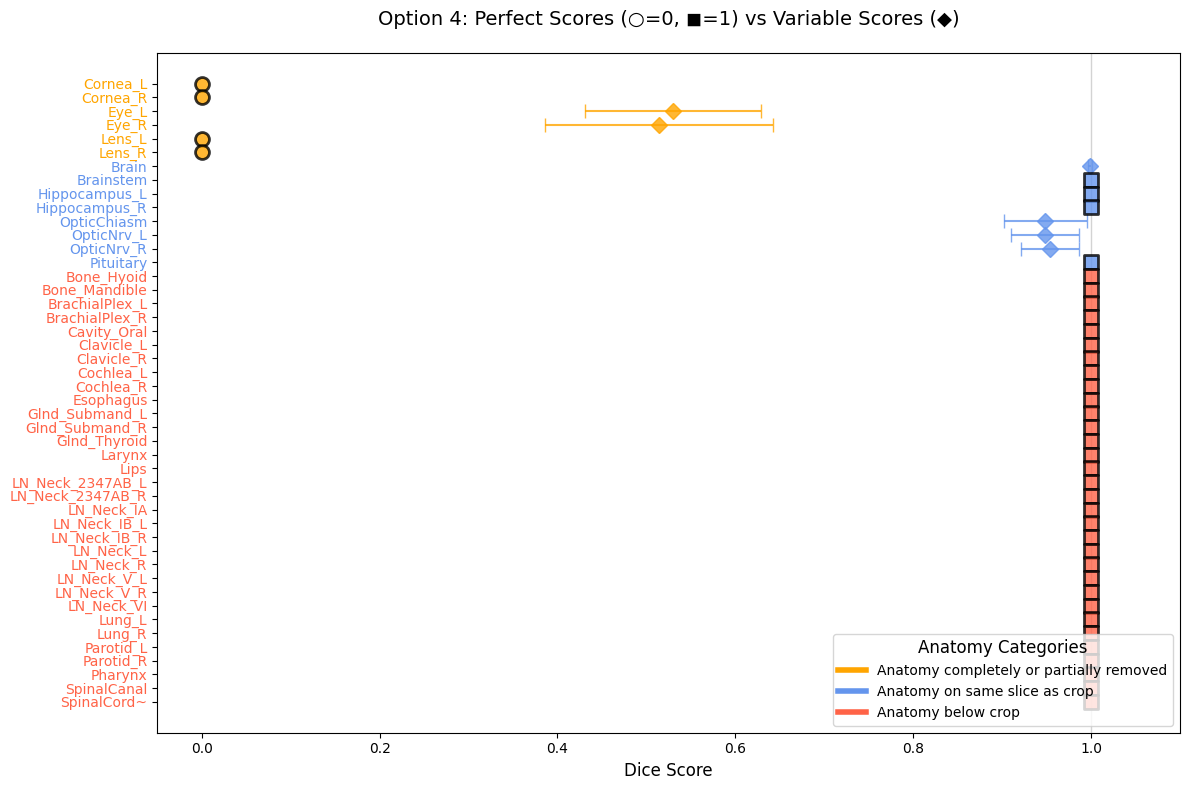

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your dict_organs data and organs_1 list
# Replace these with your actual data variables

# Define color mapping for each category
category_colors = {
    'Cropped': 'orange',
    'Overlapping': 'cornflowerblue', 
    'Below': 'tomato'
}

# Create organ classification
organ_classification = {}
for o in organs_1:  # Replace with your actual organs list
    if 'Eye' in o or 'Lens' in o or 'Cornea' in o:
        organ_classification[o] = 'Cropped'
    elif 'Brain' in o or 'Optic' in o or 'Pituitary' in o or 'Hippo' in o:
        organ_classification[o] = 'Overlapping'
    else:
        organ_classification[o] = 'Below'

# Group organs by classification
cropped_organs = [o for o in organs_1 if organ_classification[o] == 'Cropped']
overlapping_organs = [o for o in organs_1 if organ_classification[o] == 'Overlapping']
below_organs = [o for o in organs_1 if organ_classification[o] == 'Below']
ordered_organs = cropped_organs + overlapping_organs + below_organs

# Calculate statistics
organ_means = {organ: np.mean(dict_organs[organ]) for organ in ordered_organs}
organ_stddevs = {organ: np.std(dict_organs[organ]) for organ in ordered_organs}
organ_medians = {organ: np.median(dict_organs[organ]) for organ in ordered_organs}

# Convert to lists for plotting
labels = ordered_organs  # Use display names if available
means = [organ_means[organ] for organ in ordered_organs]
stddevs = [organ_stddevs[organ] for organ in ordered_organs]
medians = [organ_medians[organ] for organ in ordered_organs]
colors = [category_colors[organ_classification[organ]] for organ in ordered_organs]

# --- OPTION 1: Enhanced Bar Plot with Error Bars ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 16))

# Option 1: Mean with error bars
bars = ax1.barh(range(len(labels)), means, xerr=stddevs, capsize=3, 
                color=[c for c in colors], alpha=0.7, edgecolor='black')
ax1.set_yticks(range(len(labels)))
ax1.set_yticklabels(labels, fontsize=10)
ax1.set_xlabel('Dice Score', fontsize=12)
ax1.set_title('Option 1: Mean Dice Scores with Standard Deviation', fontsize=14, pad=20)
ax1.set_xlim(0, 1.1)
ax1.axvline(x=1, color='lightgray', linestyle='-', linewidth=1)
ax1.invert_yaxis()

# Color y-axis labels
for i, label in enumerate(ax1.get_yticklabels()):
    label.set_color(colors[i])

# --- OPTION 2: Violin Plot ---
# Create data for violin plot
violin_data = [dict_organs[organ] for organ in ordered_organs]
parts = ax2.violinplot(violin_data, vert=False, showmeans=True, showmedians=True)

# Customize violin plot colors
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)

ax2.set_yticks(range(1, len(labels) + 1))
ax2.set_yticklabels(labels, fontsize=10)
ax2.set_xlabel('Dice Score', fontsize=12)
ax2.set_title('Option 2: Violin Plot (Shows Distribution Shape)', fontsize=14, pad=20)
ax2.set_xlim(0, 1.1)
ax2.axvline(x=1, color='lightgray', linestyle='-', linewidth=1)
ax2.invert_yaxis()

# Color y-axis labels
for i, label in enumerate(ax2.get_yticklabels()):
    label.set_color(colors[i])

# --- OPTION 3: Strip Plot with Summary Statistics ---
y_positions = np.arange(len(labels))

# Plot all individual points with jitter
for i, organ in enumerate(ordered_organs):
    scores = dict_organs[organ]
    n_points = len(scores)
    
    # Add vertical jitter for better visibility
    jitter = np.random.normal(0, 0.1, n_points)
    y_vals = np.full(n_points, i) + jitter
    
    # Plot individual points
    ax3.scatter(scores, y_vals, alpha=0.6, s=20, color=colors[i], edgecolors='black', linewidth=0.5)
    
    # Add mean as a larger point
    ax3.scatter(means[i], i, s=100, color='black', marker='D', zorder=5)
    
    # Add median as a line if different from mean
    if abs(medians[i] - means[i]) > 0.01:
        ax3.scatter(medians[i], i, s=80, color='white', marker='|', zorder=4)

ax3.set_yticks(range(len(labels)))
ax3.set_yticklabels(labels, fontsize=10)
ax3.set_xlabel('Dice Score', fontsize=12)
ax3.set_title('Option 3: Strip Plot (All Points + Mean◆)', fontsize=14, pad=20)
ax3.set_xlim(-0.05, 1.1)
ax3.axvline(x=1, color='lightgray', linestyle='-', linewidth=1)
ax3.invert_yaxis()

# Color y-axis labels
for i, label in enumerate(ax3.get_yticklabels()):
    label.set_color(colors[i])

# Add legends to all subplots
legend_labels = ['Anatomy completely or partially removed', 
                'Anatomy on same slice as crop', 
                'Anatomy below crop']
legend_colors = ['orange', 'cornflowerblue', 'tomato']
handles = [plt.Line2D([0], [0], color=c, lw=4) for c in legend_colors]

for ax in [ax1, ax2, ax3]:
    ax.legend(handles, legend_labels, fontsize=10, title='Anatomy Categories', 
              title_fontsize=12, loc='lower right')

fig.tight_layout()
plt.show()

# --- OPTION 4: Separate plot focusing on perfect scores ---
fig2, ax4 = plt.subplots(figsize=(12, 8))

# Identify organs with perfect scores (0 or 1 with no variation)
perfect_organs = []
variable_organs = []
for organ in ordered_organs:
    if stddevs[organ_means[organ] == organ] < 0.001:  # Nearly zero std
        perfect_organs.append(organ)
    else:
        variable_organs.append(organ)

# Plot with different symbols for perfect vs variable scores
for i, organ in enumerate(ordered_organs):
    mean_score = means[i]
    std_score = stddevs[i]
    
    if std_score < 0.001:  # Perfect score
        # Use different symbols for 0 and 1
        symbol = 'o' if mean_score < 0.5 else 's'
        size = 100
        ax4.scatter(mean_score, i, s=size, color=colors[i], marker=symbol, 
                   edgecolors='black', linewidth=2, zorder=5, alpha=0.8)
    else:  # Variable score
        ax4.errorbar(mean_score, i, xerr=std_score, fmt='D', markersize=8,
                    color=colors[i], capsize=5, alpha=0.8)

ax4.set_yticks(range(len(labels)))
ax4.set_yticklabels(labels, fontsize=10)
ax4.set_xlabel('Dice Score', fontsize=12)
ax4.set_title('Option 4: Perfect Scores (○=0, ◼=1) vs Variable Scores (◆)', fontsize=14, pad=20)
ax4.set_xlim(-0.05, 1.1)
ax4.axvline(x=1, color='lightgray', linestyle='-', linewidth=1)
ax4.invert_yaxis()

# Color y-axis labels
for i, label in enumerate(ax4.get_yticklabels()):
    label.set_color(colors[i])

ax4.legend(handles, legend_labels, fontsize=10, title='Anatomy Categories', 
           title_fontsize=12, loc='lower right')

fig2.tight_layout()
plt.show()

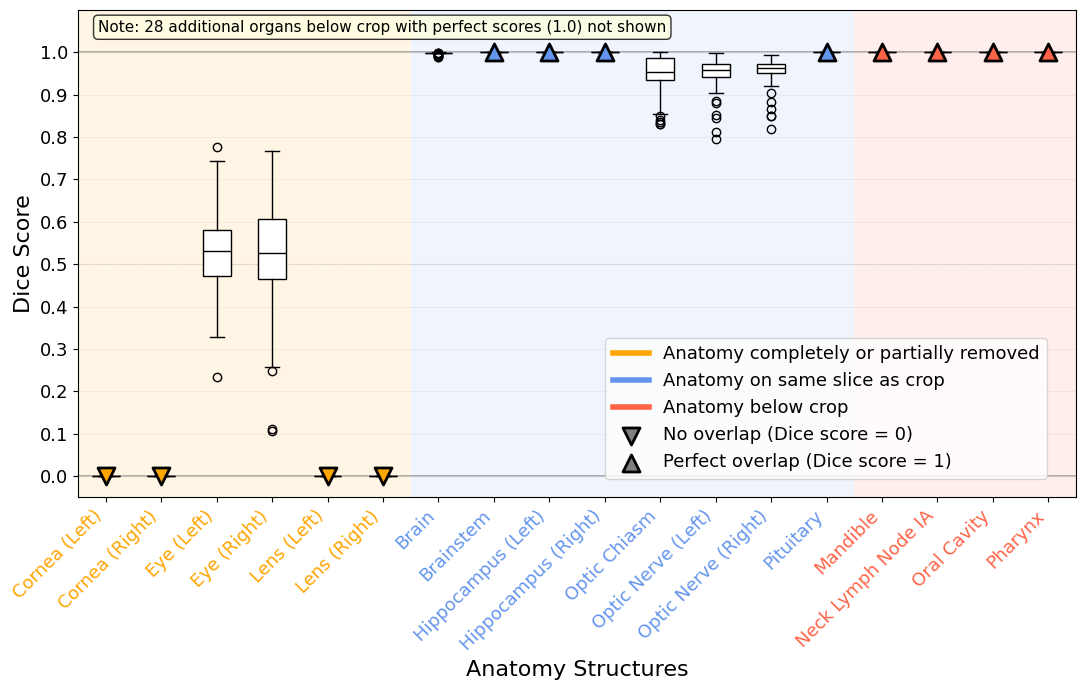

In [62]:

# Your selected organs
selected_organs = ['Cornea_L', 'Cornea_R', 'Eye_L', 'Eye_R', 'Lens_L','Lens_R','Brain', 'Brainstem', 
                   'Hippocampus_L', 'Hippocampus_R', 'OpticChiasm','OpticNrv_L', 'OpticNrv_R', 
                    'Pituitary', 'Bone_Mandible', 'LN_Neck_IA', 
                   'Cavity_Oral', 'Pharynx']

# Define colors based on your classification
colors = ['orange'] * 6 + ['cornflowerblue'] * 8 + ['tomato'] * 4

# Filter data for selected organs
filtered_data = {organ: dict_organs[organ] for organ in selected_organs}

# Convert to display names if you have the mapping
labels = [selected_organs_dict.get(x, x) for x in selected_organs] 
# Or use: labels = selected_organs

data = list(filtered_data.values())

# Calculate means and identify perfect scores
organ_means = [np.mean(scores) for scores in data]
organ_stds = [np.std(scores) for scores in data]

fig, ax = plt.subplots(figsize=(11, 7))

# Add helpful gridlines (behind everything)
# Major gridlines at 0 and 1 (darker)
ax.axhline(y=0, color='gray', linestyle='-', linewidth=1.2, alpha=0.8, zorder=1)
ax.axhline(y=1, color='gray', linestyle='-', linewidth=1.2, alpha=0.8, zorder=1)

# Medium gridline at 0.5 (solid but light)
ax.axhline(y=0.5, color='lightgray', linestyle='-', linewidth=0.8, alpha=0.6, zorder=1)

# Fine gridlines at every 0.1 interval (very light)
for y_val in [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9]:
    ax.axhline(y=y_val, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.4, zorder=1)

# Create background shading for each category (above gridlines but behind boxes)
for i in range(len(colors)):
    ax.axvspan(i + 0.5, i + 1.5, facecolor=colors[i], alpha=0.1, zorder=2)

# Create box plots with white boxes (above gridlines)
boxplots = ax.boxplot(data, vert=True, patch_artist=True, zorder=3)

# Customize the box plot colors
for patch in boxplots['boxes']:
    patch.set_facecolor('white')
    patch.set_edgecolor('black')

# Set the mean and quartile lines to black
for partname in ('whiskers', 'caps', 'medians', 'fliers'):
    plt.setp(boxplots[partname], color='black')

# Add markers for perfect scores (0s and 1s) using category colors
for i, (scores, mean_val, std_val) in enumerate(zip(data, organ_means, organ_stds)):
    x_pos = i + 1  # Box plot positions start at 1
    organ_color = colors[i]  # Use the category color for this organ
    
    # Check if this organ has perfect scores
    if std_val == 0:  
        if mean_val == 0:  # Complete failure (0s)
            ax.scatter(x_pos, 0, s=150, color=organ_color, marker='v', 
                      edgecolors='black', linewidth=2, zorder=10, 
                      label='No overlap (Dice score = 0)' if i == 0 else "")
        elif mean_val == 1:  # Perfect segmentation (1s)
            ax.scatter(x_pos, 1, s=150, color=organ_color, marker='^', 
                      edgecolors='black', linewidth=2, zorder=10,
                      label='Perfect overlap (Dice score = 1)' if i == 0 else "")
    else:
        # For organs with some 0s or 1s mixed with other scores
        unique_scores = np.unique(scores)
        
        # Add markers for any 0s
        if 0 in unique_scores:
            count_zeros = np.sum(scores == 0)
            if count_zeros > 0:
                # Add small jitter to show multiple 0s if they exist
                jitter = np.random.normal(0, 0.02, count_zeros)
                ax.scatter([x_pos] * count_zeros + jitter, [0] * count_zeros, 
                          s=80, color=organ_color, marker='v', alpha=0.7,
                          edgecolors='black', linewidth=1, zorder=9)
        
        # Add markers for any 1s
        if 1 in unique_scores:
            count_ones = np.sum(scores == 1)
            if count_ones > 0:
                # Add small jitter to show multiple 1s if they exist
                jitter = np.random.normal(0, 0.02, count_ones)
                ax.scatter([x_pos] * count_ones + jitter, [1] * count_ones, 
                          s=80, color=organ_color, marker='^', alpha=,
                          edgecolors='black', linewidth=1, zorder=9)

# Add labels and formatting
ax.set_ylabel('Dice Score', fontsize=16)
ax.set_xlabel('Anatomy Structures', fontsize=16)

# Add "..." after the last organ to indicate more organs exist
extended_labels = labels + ['...']
ax.set_xticks(np.arange(1, len(extended_labels) + 1))
ax.set_xticklabels(extended_labels, rotation=45, ha='right', fontsize=13)

# Add helpful gridlines
ax.axhline(y=0, color='lightgray', linestyle='-', linewidth=1, alpha=0.7)
ax.axhline(y=1, color='lightgray', linestyle='-', linewidth=1, alpha=0.7)
ax.axhline(y=0.5, color='lightgray', linestyle='--', linewidth=0.8, alpha=0.5)
# ax.axhline(y=0.25, color='lightgray', linestyle=':', linewidth=0.6, alpha=0.4)
# ax.axhline(y=0.75, color='lightgray', linestyle=':', linewidth=0.6, alpha=0.4)

# Highlight the labels on the x-axis (including the "..." with tomato color)
extended_colors = colors + ['tomato']
for i, label in enumerate(ax.get_xticklabels()):
    label.set_color(extended_colors[i])

# Adjust y-axis to show gridlines at every 0.1
ax.set_ylim(-0.05, 1.1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_yticklabels([f'{tick:.1f}' for tick in np.arange(0, 1.1, 0.1)], fontsize=13)

# Create single unified legend without title
legend_elements = []

# Add category legend items
category_labels = ['Anatomy completely or partially removed', 
                  'Anatomy on same slice as crop', 
                  'Anatomy below crop']
category_colors_legend = ['orange', 'cornflowerblue', 'tomato']
for color, label in zip(category_colors_legend, category_labels):
    legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=label))

# Add extreme score legend items
legend_elements.append(plt.scatter([], [], s=150, color='gray', marker='v', 
                                 edgecolors='black', linewidth=2, 
                                 label='No overlap (Dice score = 0)'))
legend_elements.append(plt.scatter([], [], s=150, color='gray', marker='^', 
                                 edgecolors='black', linewidth=2, 
                                 label='Perfect overlap (Dice score = 1)'))

# Create single legend
ax.legend(handles=legend_elements, fontsize=13, loc='lower right', 
          bbox_to_anchor=(0.98, 0.02))

# Optional: Add a note about the additional organs
ax.text(0.02, 0.98, f'Note: 28 additional organs below crop with perfect scores (1.0) not shown', 
        transform=ax.transAxes, fontsize=11
, va='top', ha='left',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.8))

fig.tight_layout()
plt.show()

In [55]:
selected_organs_dict = { 'Cornea_L': 'Cornea (Left)',
                   'Cornea_R': 'Cornea (Right)', 
                   'Eye_L': 'Eye (Left)', 
                   'Eye_R': 'Eye (Right)', 
                        'Lens_R':'Lens (Right)',
                        'Lens_L':'Lens (Left)',
                   'Brain':'Brain', 
                   'OpticNrv_R': 'Optic Nerve (Right)', 
                   'OpticNrv_L': 'Optic Nerve (Left)', 
                   'OpticChiasm': 'Optic Chiasm', 
                   'Cavity_Oral': 'Oral Cavity', 
                   'Bone_Mandible': 'Mandible',
                   'Pharynx': 'Pharynx',
                   'LN_Neck_IA':'Neck Lymph Node IA',
                    'Pituitary':'Pituitary',
                    'Brainstem':'Brainstem',
                    'Hippocampus_L': 'Hippocampus (Left)',
                        'Hippocampus_R':'Hippocampus (Right)'
                  }
                   #'Glnd_Thyroid','Esophagus', 'LN_Neck_IA','LN_Neck_VI']

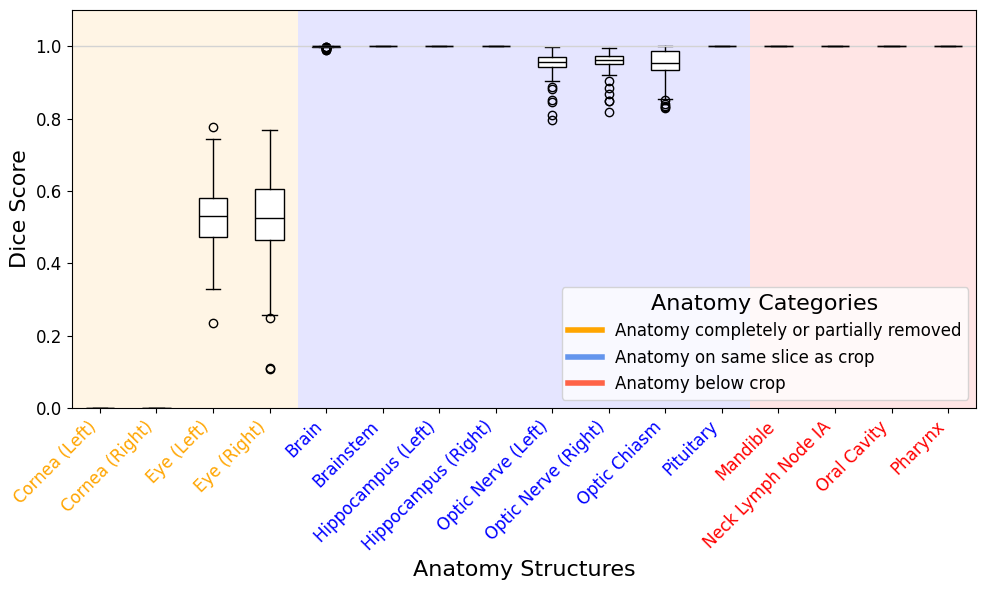

In [56]:
selected_organs = [ 'Cornea_L', 'Cornea_R', 'Eye_L', 'Eye_R', 'Brain', 'Brainstem', 'Hippocampus_L','Hippocampus_R', 'OpticNrv_L','OpticNrv_R', 'OpticChiasm','Pituitary','Bone_Mandible', 'LN_Neck_IA', 'Cavity_Oral', 'Pharynx']
colors = ['orange'] * 4 + ['blue'] * 8 + ['red'] * 4  # Define colors for the groups

filtered_data = {organ: dict_organs[organ] for organ in selected_organs}
labels = [selected_organs_dict[x] for x in list(filtered_data.keys())]
data = list(filtered_data.values()) 
fig, ax = plt.subplots(figsize=(10, 6))

# Create background shading for each category
for i in range(len(colors)):
    ax.axvspan(i + 0.5, i + 1.5, facecolor=colors[i], alpha=0.1)

# Create box plots with white boxes
boxplots = ax.boxplot(data, vert=True, patch_artist=True)

# Customize the box plot colors
for patch in boxplots['boxes']:
    patch.set_facecolor('white')
    patch.set_edgecolor('black')

# Set the mean and quartile lines to black
for partname in ('whiskers', 'caps', 'medians', 'fliers'):
    plt.setp(boxplots[partname], color='black')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Dice Score',fontsize=16)
ax.set_xlabel('Anatomy Structures',fontsize=16)
ax.set_xticks(np.arange(1, len(labels) + 1))
ax.set_xticklabels(labels, rotation=45, ha='right',fontsize=12)
ax.axhline(y=1, color='lightgray', linestyle='-', linewidth=1)



# Highlight the labels on the x-axis
for i, label in enumerate(ax.get_xticklabels()):
    label.set_color(colors[i])

# Adjust y-axis to display 1 at the top, 0 at the bottom, and extend beyond 1
ax.set_ylim(0, 1.1)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_yticklabels([f'{tick:.1f}' for tick in np.arange(0, 1.1, 0.2)],fontsize=12)

# Add legend
legend_labels = ['Anatomy completely or partially removed', 'Anatomy on same slice as crop', 'Anatomy below crop']
handles = [plt.Line2D([0], [0], color=c, lw=4) for c in ['orange', 'cornflowerblue', 'tomato']]
ax.legend(handles, legend_labels, fontsize=12, title='Anatomy Categories', title_fontsize='16')

fig.tight_layout()

plt.show()


In [57]:
plot_data = []
plot_labels = []
plot_colors = []

for d, l, c in zip(data, labels, colors):
    if d is not None:
        plot_data.append(d)
        plot_labels.append(l)
        plot_colors.append(c)
boxplots = ax.boxplot(plot_data, vert=True, patch_artist=True)
ax.set_xticks(np.arange(1, len(plot_labels) + 1))
ax.set_xticklabels(plot_labels, rotation=45, ha='right', fontsize=12)


[Text(1, 0, 'Cornea (Left)'),
 Text(2, 0, 'Cornea (Right)'),
 Text(3, 0, 'Eye (Left)'),
 Text(4, 0, 'Eye (Right)'),
 Text(5, 0, 'Brain'),
 Text(6, 0, 'Brainstem'),
 Text(7, 0, 'Hippocampus (Left)'),
 Text(8, 0, 'Hippocampus (Right)'),
 Text(9, 0, 'Optic Nerve (Left)'),
 Text(10, 0, 'Optic Nerve (Right)'),
 Text(11, 0, 'Optic Chiasm'),
 Text(12, 0, 'Pituitary'),
 Text(13, 0, 'Mandible'),
 Text(14, 0, 'Neck Lymph Node IA'),
 Text(15, 0, 'Oral Cavity'),
 Text(16, 0, 'Pharynx')]

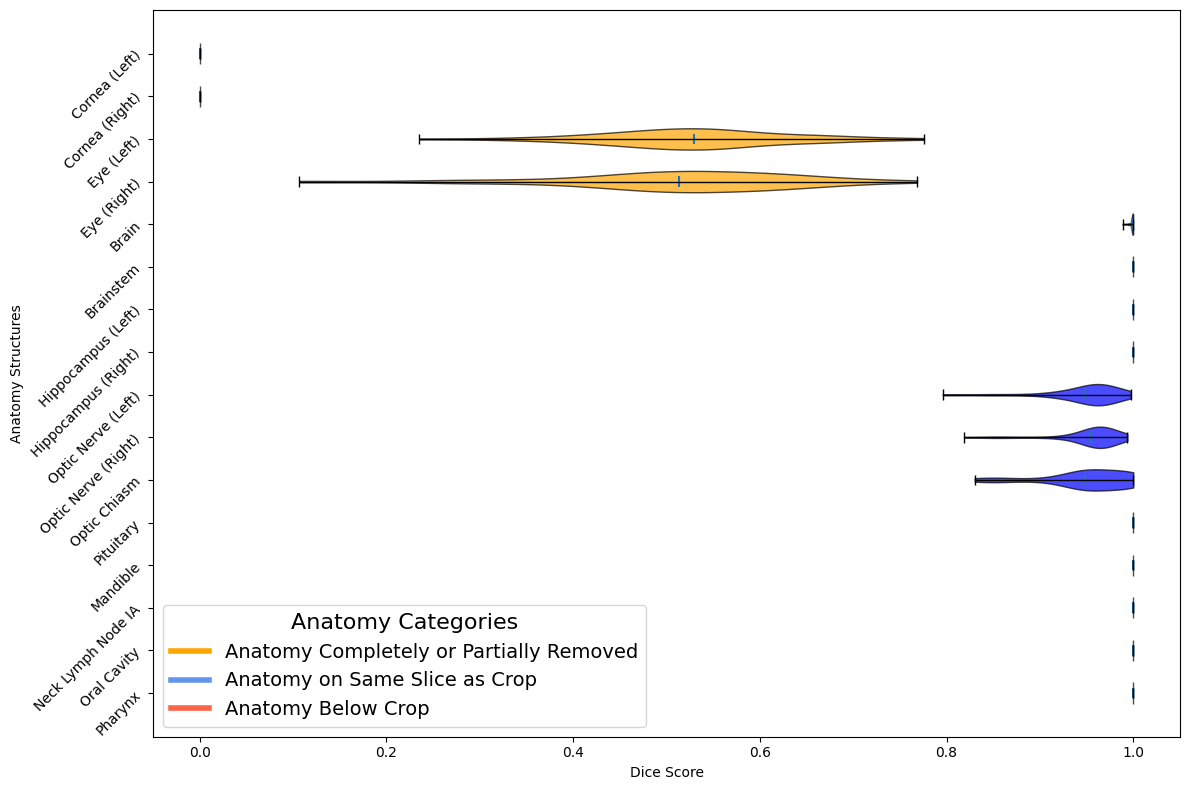

In [58]:

fig, ax = plt.subplots(figsize=(12, 8))
# Create violin plots
violins = ax.violinplot(data, vert=False, showmeans=True)

# Customize the violin plot colors
for i, violin in enumerate(violins['bodies']):
    violin.set_facecolor(colors[i])
    violin.set_edgecolor('black')
    violin.set_alpha(0.7)

# Set the mean and quartile lines to black 
for partname in ('cbars', 'cmins', 'cmaxes'): 
    vp = violins[partname] 
    vp.set_edgecolor('black') 
    vp.set_linewidth(1)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Dice Score')
ax.set_ylabel('Anatomy Structures')
ax.set_yticks(np.arange(1, len(labels) + 1))
ax.set_yticklabels(labels, rotation=45, ha='right')
ax.invert_yaxis()  # Invert y axis to have the first item at the top

# Add legend
legend_labels = ['Anatomy Completely or Partially Removed', 'Anatomy on Same Slice as Crop', 'Anatomy Below Crop']
handles = [plt.Line2D([0], [0], color=c, lw=4) for c in ['orange', 'cornflowerblue', 'tomato']]
ax.legend(handles, legend_labels, fontsize=14, title='Anatomy Categories', title_fontsize='16')

fig.tight_layout()

plt.show()



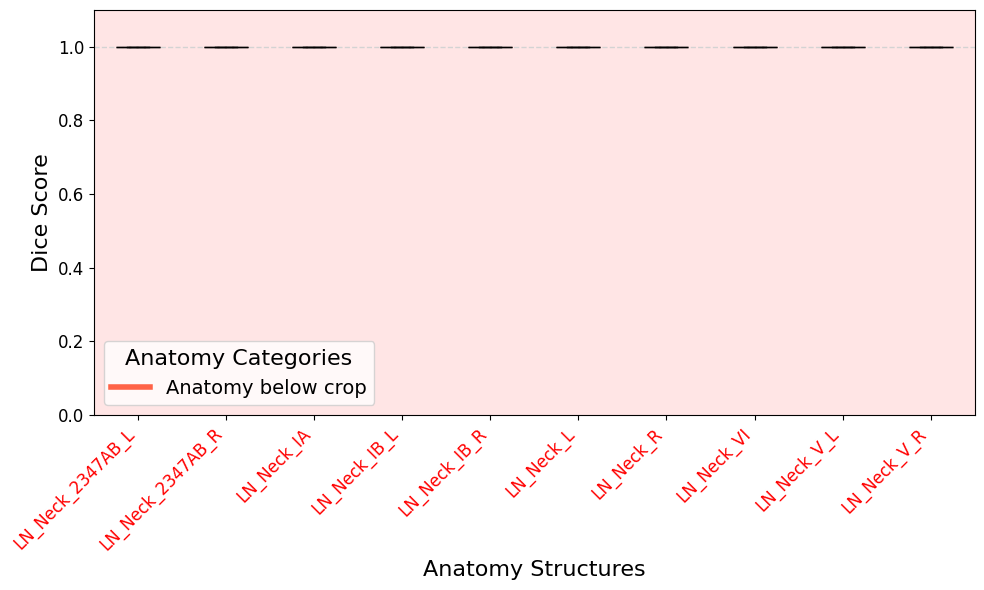

In [59]:
LNs = ['LN_Neck_2347AB_L', 'LN_Neck_2347AB_R', 'LN_Neck_IA', 'LN_Neck_IB_L', 'LN_Neck_IB_R', 'LN_Neck_L', 'LN_Neck_R', 'LN_Neck_VI', 'LN_Neck_V_L', 'LN_Neck_V_R']
LNs_data = {organ: dict_organs[organ] for organ in LNs}
labels = list(LNs_data.keys()) 
data = list(LNs_data.values()) 
colors = ['red'] * len(LNs) 

fig, ax = plt.subplots(figsize=(10, 6))

# Create background shading for each category
for i in range(len(colors)):
    ax.axvspan(i + 0.5, i + 1.5, facecolor=colors[i], alpha=0.1)

# Create box plots with white boxes
boxplots = ax.boxplot(data, vert=True, patch_artist=True)

# Customize the box plot colors
for patch in boxplots['boxes']:
    patch.set_facecolor('white')
    patch.set_edgecolor('black')

# Set the mean and quartile lines to black
for partname in ('whiskers', 'caps', 'medians', 'fliers'):
    plt.setp(boxplots[partname], color='black')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Dice Score',fontsize=16)
ax.set_xlabel('Anatomy Structures',fontsize=16)
ax.set_xticks(np.arange(1, len(labels) + 1))
ax.set_xticklabels(labels, rotation=45, ha='right',fontsize=12)
ax.axhline(y=1, color='lightgray', linestyle='--', linewidth=1)



# Highlight the labels on the x-axis
for i, label in enumerate(ax.get_xticklabels()):
    label.set_color(colors[i])

# Adjust y-axis to display 1 at the top, 0 at the bottom, and extend beyond 1
ax.set_ylim(0, 1.1)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_yticklabels([f'{tick:.1f}' for tick in np.arange(0, 1.1, 0.2)],fontsize=12)

# Add legend
legend_labels = ['Anatomy below crop']
handles = [plt.Line2D([0], [0], color=c, lw=4) for c in ['tomato']]
ax.legend(handles, legend_labels, fontsize=14, title='Anatomy Categories', title_fontsize='16')

fig.tight_layout()

plt.show()


In [60]:
not_one = []
for organ, scores in dict_organs.items():
    mean_score = np.mean(scores)
    if mean_score != 1:
        not_one.append(organ)
    std_dev = np.std(scores)
    print(f"{organ}: Mean DSC= {mean_score:.4f}, Stddev = {std_dev:.4f}")

Bone_Hyoid: Mean DSC= 1.0000, Stddev = 0.0000
Bone_Mandible: Mean DSC= 1.0000, Stddev = 0.0000
BrachialPlex_L: Mean DSC= 1.0000, Stddev = 0.0000
BrachialPlex_R: Mean DSC= 1.0000, Stddev = 0.0000
Brain: Mean DSC= 0.9986, Stddev = 0.0023
Brainstem: Mean DSC= 1.0000, Stddev = 0.0000
Cavity_Oral: Mean DSC= 1.0000, Stddev = 0.0000
Clavicle_L: Mean DSC= 1.0000, Stddev = 0.0000
Clavicle_R: Mean DSC= 1.0000, Stddev = 0.0000
Cochlea_L: Mean DSC= 1.0000, Stddev = 0.0000
Cochlea_R: Mean DSC= 1.0000, Stddev = 0.0000
Cornea_L: Mean DSC= 0.0000, Stddev = 0.0000
Cornea_R: Mean DSC= 0.0000, Stddev = 0.0000
Esophagus: Mean DSC= 1.0000, Stddev = 0.0000
Eye_L: Mean DSC= 0.5299, Stddev = 0.0989
Eye_R: Mean DSC= 0.5139, Stddev = 0.1279
Glnd_Submand_L: Mean DSC= 1.0000, Stddev = 0.0000
Glnd_Submand_R: Mean DSC= 1.0000, Stddev = 0.0000
Glnd_Thyroid: Mean DSC= 1.0000, Stddev = 0.0000
Hippocampus_L: Mean DSC= 1.0000, Stddev = 0.0000
Hippocampus_R: Mean DSC= 1.0000, Stddev = 0.0000
Larynx: Mean DSC= 1.0000, Std

# PTV Cutoff

In [122]:
remove = ['495','1036','980','1053','1074','1132','1262','1271','1275','1311','1341','1343','1380',
'1393','1396','1434','1462','1464','1481','652','715','740','742','757','780','821','827',
'862','1522','1686']
print(len(remove))
remove = []

30


In [123]:
list_all_patients = sorted([p for p in os.listdir(PATH) if 'b' not in p and 'old' not in p and p not in remove], key=int,reverse=False)
print(len(list_all_patients))

630


In [268]:
patient_list = [19, 22, 23, 35, 43, 51, 54, 59, 60, 70, 77, 81, 100, 101, 103, 108, 112, 115, 118, 146, 147, 153, 169, 172, 257, 272, 274, 294, 359, 384, 390, 408, 424, 425, 432, 436, 437, 439, 440, 443, 447, 448, 451, 452, 453, 454, 456, 459, 460, 462, 463, 464, 466, 467, 468, 469, 471, 473, 474, 476, 478, 483, 484, 487, 490, 498, 502, 503, 504, 506, 507, 509, 510, 512, 513, 514, 515, 517, 518, 520, 600, 602, 604, 606, 607, 611, 613, 614, 615, 616, 617, 618, 619, 621, 622, 623, 624, 625, 628, 629, 630, 631, 632, 633, 634, 635, 637, 638, 639, 640, 641, 644, 645, 646, 647, 648, 651, 653, 655, 656, 657, 659, 660, 661, 662, 663, 665, 666, 667, 668, 670, 671, 672, 673, 674, 675, 676, 677, 679, 680, 681, 682, 684, 685, 688, 689, 690, 692, 694, 695, 696, 700, 702, 703, 704, 707, 709, 710, 711, 713, 714, 718, 719, 721, 722, 723, 725, 726, 728, 729, 730, 734, 735, 736, 737, 738, 743, 744, 746, 747, 748, 749, 750, 751, 753, 754, 755, 758, 759, 760, 761, 764, 765, 766, 767, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 781, 782, 783, 784, 786, 787, 788, 789, 790, 791, 793, 794, 797, 798, 799, 800, 801, 802, 803, 804, 805, 808, 811, 812, 813, 814, 817, 820, 822, 823, 825, 826, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 841, 842,  843, 844, 845, 846, 847, 848, 850, 851, 852, 853, 855, 856, 857, 858, 859, 860, 861, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 927, 928, 929, 931, 932, 933, 934, 935, 936, 937, 938, 939, 941, 942, 943, 944, 945, 946, 949, 950, 951, 952, 953, 954, 955, 956, 957, 960, 961, 962, 963, 964, 965, 966, 967, 968, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 990, 991, 1001, 1013, 1019, 1021, 1026, 1027, 1044, 1056, 1058, 1059, 1071, 1075, 1081, 1100, 1109, 1130, 1143, 1145, 1149, 1165, 1167, 1177, 1184, 1188, 1189, 1198, 1209, 1215, 1221, 1233, 1252, 1254, 1255, 1268, 1269, 1288, 1289, 1296, 1306, 1314, 1317, 1325, 1328, 1331, 1332, 1333, 1340, 1350, 1360, 1364, 1374, 1381, 1400, 1402, 1428, 1432, 1433, 1438, 1443, 1444, 1449, 1461, 1466, 1467, 1470, 1471, 1482, 1488, 1489, 1493, 1494, 1497, 1502, 1503, 1506, 1508, 1511, 1514, 1515, 1518, 1520, 1521, 1523, 1525, 1527, 1530, 1538, 1544, 1545, 1546, 1549, 1550, 1551, 1552, 1558, 1559, 1563, 1565, 1570, 1575, 1594, 1598, 1607, 1603, 1611, 1624, 1634, 1641, 1645, 1651, 1655, 1659, 1662, 1665, 1667, 1670, 1671, 1673, 1675, 1678, 1694, 1695, 1696, 1699, 1700, 1714, 1723, 1724, 1726, 1727, 1730, 1736, 1759, 1761, 1763, 1765, 1766, 1774, 1780, 1781, 1783, 1787, 1790, 1804, 1806, 1809, 1821, 1822, 1824, 1826, 1831, 1832, 1834, 1838, 1844, 1850, 1856, 1857, 1860, 1865, 1870, 1873, 1876, 1880, 1886, 1888, 1889, 1891, 1892, 1893, 1895, 1898, 1899, 1901, 1902, 1905, 1907, 1911, 1918, 1923, 1932, 1935, 1940, 1942, 1944, 1949, 1950, 1951, 1954, 1955, 1960, 1961, 1965, 1969, 1974, 1978, 1982, 1987, 1991, 1994, 1995, 1999, 2000, 2003, 2013, 2015, 2017, 2018, 2019, 2020, 2021, 2022, 2026, 2027, 2030, 2031, 2033, 2035, 2036, 2037, 2040,2041, 2042, 2043, 2044,2045, 2047, 2048, 2051, 2054, 2055, 2056, 2057, 2058, 2059, 2061, 2062, 2066, 2068, 2073, 2074, 2075, 2076, 2078]
print(len(patient_list))

622


In [269]:
list_all_patients = patient_list

In [270]:
p_prev = 0
for p in patient_list:
    if p == p_prev:
    # if int(p) not in patient_list:
        print(p)
    p_prev = p

In [271]:
PTV_cutoffs = {}
no_eyes = []
for p in list_all_patients:
    print("******", p , "*******")
    p = str(p)
    # if p=='853':
    #     continue
    patient_path = PATH+p+'/'
    CT_list = [d for d in os.listdir(patient_path) if d[9:11] == 'CT' and len(d) == 23]
    if len(CT_list) > 2:
        print(p,"has",len(CT_list),"CTs.")
    PTV_cutoffs[p] = {}    
    for CT in CT_list:
        print(CT)
        CT_path = patient_path+CT+'/'
        RS_file = [rs for rs in os.listdir(CT_path) if 'RS' in rs][0]
        RS = dcm.dcmread(CT_path+RS_file)
        
#         print(p, CT, RS_file)
        
        
        eye_ROI_names = find_ROI_names(RS,keyword='eye')
        
        if len(eye_ROI_names) != 2:
            print(p, eye_ROI_names)
        if len(eye_ROI_names) == 0:
            
            eye_ROI_names = find_ROI_names(RS,keyword='orbit')
            if len(eye_ROI_names) == 0:
                 eye_ROI_names = find_ROI_names(RS,keyword='globe')
            if len(eye_ROI_names) == 0:
                print("***Patient", p, "CT",CT, "has no eye contours... ***")
                no_eyes.append(p)
                print(find_ROI_names(RS))
                continue
   
            
        dict_contours, z_lists = get_all_ROI_contours(eye_ROI_names, RS)
#         all_z_slices = sorted(z_lists[0] + [z for z in z_lists[1] if z not in z_lists[0]])
        all_z_slices = []
        for z_list in z_lists:
            all_z_slices = sorted(all_z_slices + [z for z in z_list if z not in all_z_slices])
        
        PTV_names = [p for p in find_ROI_names(RS,"PTV") if '!' not in p and 'z' not in p.lower() and 'mod' not in p.lower() and 'M1' not in p and 'M2' not in p and '+' not in p and 'and' not in p.lower() and 'E-PTV' not in p and 'NON' not in p and '-ptv' not in p.lower() and 'avoid' not in p.lower() and 'old' not in p.lower() and p!='ptv70+0.3']
        print(PTV_names)
        if len(PTV_names) ==0:
            print("______________________________________________________________")
            print(find_ROI_names(RS,'PTV'))
            print("______________________________________________________________")
            PTV_names = [f for f in find_ROI_names(RS,'PTV') if 'all' in f.lower()]
            if len(PTV_names) ==0:
                PTV_names = [f for f in find_ROI_names(RS,'PTV') if 'eval' in f.lower()]
            if len(PTV_names) ==0:
                 PTV_names = [f for f in find_ROI_names(RS,'PTV') if '70' in f]
            if len(PTV_names) ==0:
                 PTV_names = [f for f in find_ROI_names(RS,'PTV') if '60' in f or '66' in f]
        
            if len(PTV_names) ==0:    
                print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
        PTV_dict_contours, z_lists = get_all_ROI_contours(PTV_names, RS)
        
        all_z_slices_PTV = []
        for z_list in z_lists:
            all_z_slices_PTV = sorted(all_z_slices_PTV + [z for z in z_list if z not in all_z_slices_PTV])
        
        PTV_slices_cut = 0
        len_PTV_slices = len(all_z_slices_PTV)
        
        for z in all_z_slices_PTV:
            if z in all_z_slices or z>min(all_z_slices):
                PTV_slices_cut += 1
        
        
        PTV_cutoffs[p][CT] = {}
        PTV_cutoffs[p][CT]['total'] = len_PTV_slices
        PTV_cutoffs[p][CT]['cut'] = PTV_slices_cut
        
        

        

****** 19 *******
20180411_CT_09_APR_2018
['PTV_ALL', 'PTV70', 'PTV60', 'PTV56']
20180515_CT_10_MAY_2018
['PTV_ALL', 'PTV56', 'PTV60', 'PTV70']
****** 22 *******
20180921_CT_13_SEP_2018
['PTV_7000', 'PTV_6300', 'PTV_5600', 'PTV_ALL', 'opt_PTV56_cover']
****** 23 *******
20180831_CT_22_AUG_2018
['PTV_ALL', 'PTV70', 'PTV60', 'PTV56', 'PTV56_opt', 'PTV60opt']
****** 35 *******
20180209_CT_06_FEB_2018
['PTV56', 'PTV60', 'PTV70']
20171220_CT_14_DEC_2017
['PTV_ALL', 'PTV70', 'PTV60', 'PTV56']
****** 43 *******
20190131_CT_24_JAN_2019
['PTV_7000-05']
****** 51 *******
20190430_CT_24_APR_2019
['PTV_7000', 'PTV_5600']
****** 54 *******
20190122_CT_14_JAN_2019
['PTV_7000-05', 'PTV_Eval_7000']
20190225_CT_19_FEB_2019
[]
______________________________________________________________
['Cavity_Oral-PTV', 'M1 PTV_7000-05', 'M1 PTV!_6000-05', 'M1 PTV_EVAL_7000']
______________________________________________________________
****** 59 *******
20180807_CT_31_JUL_2018
[]
_________________________________

In [272]:
PTV_cutoffs

{'19': {'20180411_CT_09_APR_2018': {'total': 80, 'cut': 0},
  '20180515_CT_10_MAY_2018': {'total': 78, 'cut': 0}},
 '22': {'20180921_CT_13_SEP_2018': {'total': 65, 'cut': 0}},
 '23': {'20180831_CT_22_AUG_2018': {'total': 96, 'cut': 0}},
 '35': {'20180209_CT_06_FEB_2018': {'total': 94, 'cut': 0},
  '20171220_CT_14_DEC_2017': {'total': 93, 'cut': 0}},
 '43': {'20190131_CT_24_JAN_2019': {'total': 15, 'cut': 0}},
 '51': {'20190430_CT_24_APR_2019': {'total': 77, 'cut': 0}},
 '54': {'20190122_CT_14_JAN_2019': {'total': 49, 'cut': 11},
  '20190225_CT_19_FEB_2019': {'total': 27, 'cut': 0}},
 '59': {'20180807_CT_31_JUL_2018': {'total': 105, 'cut': 4},
  '20180705_CT_27_JUN_2018': {'total': 140, 'cut': 5}},
 '60': {'20181004_CT_26_SEP_2018': {'total': 122, 'cut': 0}},
 '70': {'20180221_CT_14_FEB_2018': {'total': 113, 'cut': 0},
  '20180403_CT_28_MAR_2018': {'total': 120, 'cut': 0}},
 '77': {'20190320_CT_13_MAR_2019': {'total': 29, 'cut': 0}},
 '81': {'20190125_CT_16_JAN_2019': {'total': 97, 'cut

In [273]:
remove = []#['853']

In [274]:
# Number of patients counted
total_ps = 0
not_count = 0
for p in PTV_cutoffs:
    # if p == '853':
    #     continue
    
    if bool(PTV_cutoffs[p]) and p not in remove:# and p!='1514':
        
        total_ps+=1
    else:
        print(p)
        not_count+=1

total_CTs = 0

for p in PTV_cutoffs:
    # if p == '853':
    #     continue
    
    for CT in PTV_cutoffs[p]:
        if p not in remove:
            total_CTs+=1
        
print("Total patients with dirs:",len(list_all_patients)-len(remove))
print("Total patients counted:", total_ps)
# print("Total CTs:",)
print("Total CTs counted:",total_CTs)
print("Patients without eyes:",len(no_eyes))

853
1611
1641
1645
1651
1655
1662
1694
1695
1699
1700
1726
1736
1761
1780
1787
1790
1809
1821
1822
1824
1832
1850
1860
1865
1873
1880
1886
1889
1899
1907
1940
1965
2020
2075
Total patients with dirs: 622
Total patients counted: 587
Total CTs counted: 793
Patients without eyes: 36


In [275]:
PTV_cutoffs

{'19': {'20180411_CT_09_APR_2018': {'total': 80, 'cut': 0},
  '20180515_CT_10_MAY_2018': {'total': 78, 'cut': 0}},
 '22': {'20180921_CT_13_SEP_2018': {'total': 65, 'cut': 0}},
 '23': {'20180831_CT_22_AUG_2018': {'total': 96, 'cut': 0}},
 '35': {'20180209_CT_06_FEB_2018': {'total': 94, 'cut': 0},
  '20171220_CT_14_DEC_2017': {'total': 93, 'cut': 0}},
 '43': {'20190131_CT_24_JAN_2019': {'total': 15, 'cut': 0}},
 '51': {'20190430_CT_24_APR_2019': {'total': 77, 'cut': 0}},
 '54': {'20190122_CT_14_JAN_2019': {'total': 49, 'cut': 11},
  '20190225_CT_19_FEB_2019': {'total': 27, 'cut': 0}},
 '59': {'20180807_CT_31_JUL_2018': {'total': 105, 'cut': 4},
  '20180705_CT_27_JUN_2018': {'total': 140, 'cut': 5}},
 '60': {'20181004_CT_26_SEP_2018': {'total': 122, 'cut': 0}},
 '70': {'20180221_CT_14_FEB_2018': {'total': 113, 'cut': 0},
  '20180403_CT_28_MAR_2018': {'total': 120, 'cut': 0}},
 '77': {'20190320_CT_13_MAR_2019': {'total': 29, 'cut': 0}},
 '81': {'20190125_CT_16_JAN_2019': {'total': 97, 'cut

In [276]:
all_CT_count = 0
cts_not_included = 0
for p in list_all_patients:
    

    p = str(p)
    # if p=='853':
    #     continue
    patient_path = PATH+p+'/'
    CT_list = [d for d in os.listdir(patient_path) if d[9:11] == 'CT' and len(d) == 23]
    all_CT_count += len(CT_list)
    # if len(CT_list) > 1:
    #     print(p,CT_list)
    for ct in CT_list:
        if ct not in PTV_cutoffs[p]:
            cts_not_included +=1
            print(p,ct)
    # if len(CT_list) > 2:
    #     print(p,"has",len(CT_list),"CTs.")
print("Total CTs:",all_CT_count)
print("Total CTs not included:",cts_not_included)

853 20200304_CT_26_FEB_2020
1467 20230920_CT_20_SEP_2023
1611 20210309_CT_30_JUN_2017
1641 20210308_CT_16_OCT_2017
1645 20210226_CT_02_NOV_2017
1651 20210226_CT_11_DEC_2017
1655 20210226_CT_03_JAN_2018
1662 20210308_CT_01_MAR_2018
1694 20210309_CT_25_SEP_2018
1695 20210226_CT_04_OCT_2018
1699 20210309_CT_05_NOV_2018
1700 20181116_CT_08_NOV_2018
1726 20210308_CT_07_MAY_2019
1736 20210309_CT_27_JUN_2019
1761 20191122_CT_15_NOV_2019
1780 20210309_CT_26_FEB_2020
1787 20210309_CT_02_APR_2020
1790 20210309_CT_27_APR_2020
1809 20210409_CT_17_SEP_2020
1821 20210409_CT_10_NOV_2020
1822 20210409_CT_11_NOV_2020
1824 20210409_CT_19_NOV_2020
1832 20210107_CT_05_JAN_2021
1850 20210414_CT_07_APR_2021
1860 20210526_CT_21_MAY_2021
1865 20210629_CT_25_JUN_2021
1873 20210816_CT_12_AUG_2021
1880 20210922_CT_21_SEP_2021
1886 20211027_CT_26_OCT_2021
1889 20211117_CT_10_NOV_2021
1899 20220127_CT_24_JAN_2022
1907 20220224_CT_17_FEB_2022
1940 20220818_CT_15_AUG_2022
1965 20221229_CT_22_DEC_2022
2020 20231004_C

In [277]:
cts_not_included

36

In [278]:
for p in no_eyes:
    CT_list = [d for d in os.listdir(PATH+p) if d[9:11] == 'CT' and len(d) == 23]
    for CT in CT_list:
        print("*****",p,"***")
        CT_path = PATH+p+'/'+CT+'/'
        print(CT)
        RS_file = [rs for rs in os.listdir(CT_path) if 'RS' in rs][0]
        RS = dcm.dcmread(CT_path+RS_file)
        print("EYE:",find_ROI_names(RS,keyword='eye'))
        print("ORBIT:",find_ROI_names(RS,keyword='orbit'))
        print("GLOBE:",find_ROI_names(RS,keyword='globe'))

***** 853 ***
20200304_CT_26_FEB_2020
EYE: []
ORBIT: []
GLOBE: []
***** 1467 ***
20230920_CT_20_SEP_2023
EYE: []
ORBIT: []
GLOBE: []
***** 1467 ***
20230907_CT_01_SEP_2023
EYE: ['Eye_R', 'Eye_L']
ORBIT: []
GLOBE: []
***** 1611 ***
20210309_CT_30_JUN_2017
EYE: []
ORBIT: []
GLOBE: []
***** 1641 ***
20210308_CT_16_OCT_2017
EYE: []
ORBIT: []
GLOBE: []
***** 1645 ***
20210226_CT_02_NOV_2017
EYE: []
ORBIT: []
GLOBE: []
***** 1651 ***
20210226_CT_11_DEC_2017
EYE: []
ORBIT: []
GLOBE: []
***** 1655 ***
20210226_CT_03_JAN_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1662 ***
20210308_CT_01_MAR_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1694 ***
20210309_CT_25_SEP_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1695 ***
20210226_CT_04_OCT_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1699 ***
20210309_CT_05_NOV_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1700 ***
20181116_CT_08_NOV_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1726 ***
20210308_CT_07_MAY_2019
EYE: []
ORBIT: []
GLOBE: []
***** 1736 ***
20210309_CT_27_JUN_2019
EYE: []


In [279]:

CT_list = [d for d in os.listdir(PATH+p) if d[9:11] == 'CT' and len(d) == 23]
for CT in CT_list:
    print("*****",p,"***")
    CT_path = PATH+p+'/'+CT+'/'
    RS_file = [rs for rs in os.listdir(CT_path) if 'RS' in rs][0]

***** 2075 ***


In [280]:
PTV_cutoffs

{'19': {'20180411_CT_09_APR_2018': {'total': 80, 'cut': 0},
  '20180515_CT_10_MAY_2018': {'total': 78, 'cut': 0}},
 '22': {'20180921_CT_13_SEP_2018': {'total': 65, 'cut': 0}},
 '23': {'20180831_CT_22_AUG_2018': {'total': 96, 'cut': 0}},
 '35': {'20180209_CT_06_FEB_2018': {'total': 94, 'cut': 0},
  '20171220_CT_14_DEC_2017': {'total': 93, 'cut': 0}},
 '43': {'20190131_CT_24_JAN_2019': {'total': 15, 'cut': 0}},
 '51': {'20190430_CT_24_APR_2019': {'total': 77, 'cut': 0}},
 '54': {'20190122_CT_14_JAN_2019': {'total': 49, 'cut': 11},
  '20190225_CT_19_FEB_2019': {'total': 27, 'cut': 0}},
 '59': {'20180807_CT_31_JUL_2018': {'total': 105, 'cut': 4},
  '20180705_CT_27_JUN_2018': {'total': 140, 'cut': 5}},
 '60': {'20181004_CT_26_SEP_2018': {'total': 122, 'cut': 0}},
 '70': {'20180221_CT_14_FEB_2018': {'total': 113, 'cut': 0},
  '20180403_CT_28_MAR_2018': {'total': 120, 'cut': 0}},
 '77': {'20190320_CT_13_MAR_2019': {'total': 29, 'cut': 0}},
 '81': {'20190125_CT_16_JAN_2019': {'total': 97, 'cut

In [281]:
PTV_cutoffs['1467']


{'20230907_CT_01_SEP_2023': {'total': 33, 'cut': 15}}

In [282]:
CT_percentages = []

num_CTs = 0
for patient in PTV_cutoffs:
    for CT in PTV_cutoffs[patient]:
        if PTV_cutoffs[patient][CT]['total'] == 0:
            print("***",patient,PTV_cutoffs[patient],"***")
        else:
            num_CTs += 1
            percentage = PTV_cutoffs[patient][CT]['cut']/PTV_cutoffs[patient][CT]['total']*100
            CT_percentages.append(percentage)
            if percentage > 25:
                print(patient,":", percentage,"% -->",PTV_cutoffs[patient][CT]['cut'],"/",PTV_cutoffs[patient][CT]['total'])
    

108 : 54.54545454545454 % --> 18 / 33
466 : 38.46153846153847 % --> 10 / 26
638 : 32.432432432432435 % --> 12 / 37
638 : 42.857142857142854 % --> 9 / 21
690 : 38.392857142857146 % --> 43 / 112
730 : 41.17647058823529 % --> 7 / 17
842 : 44.61538461538462 % --> 29 / 65
863 : 100.0 % --> 6 / 6
868 : 40.42553191489361 % --> 19 / 47
912 : 26.82926829268293 % --> 11 / 41
936 : 51.724137931034484 % --> 15 / 29
1071 : 42.857142857142854 % --> 24 / 56
1130 : 38.333333333333336 % --> 23 / 60
1143 : 61.42857142857143 % --> 43 / 70
1402 : 40.0 % --> 18 / 45
1432 : 36.36363636363637 % --> 8 / 22
1467 : 45.45454545454545 % --> 15 / 33
1489 : 45.83333333333333 % --> 11 / 24
1514 : 44.44444444444444 % --> 8 / 18
1521 : 58.82352941176471 % --> 10 / 17
1598 : 39.53488372093023 % --> 17 / 43
1607 : 51.68539325842697 % --> 46 / 89
*** 1888 {'20211104_CT_28_OCT_2021': {'total': 44, 'cut': 1}, '20211201_CT_30_NOV_2021': {'total': 0, 'cut': 0}} ***
1901 : 39.39393939393939 % --> 13 / 33
1918 : 40.0 % --> 14 

In [283]:
CT_slices = []
cts_checked = 0
PTVs_below_cut = 0
for patient in PTV_cutoffs:
    for CT in PTV_cutoffs[patient]:
        CT_slices.append(PTV_cutoffs[patient][CT]['cut'])
        cts_checked+=1
        if PTV_cutoffs[patient][CT]['cut'] == 0:
            PTVs_below_cut+=1
    

In [284]:
def check_if_cut(slices, y_cutoff_roi, all_z_slices):
    if len(slices) == 0:
        return False
    for c_slice in slices:
        xo = []
        yo = []

        z = c_slice[2]
        if z in all_z_slices or z>min(all_z_slices):

#             xo = []
#             yo = []

            xi, yi, zi = c_slice[::3], c_slice[1::3], c_slice[2::3]
            for k,y_i in enumerate(yi):
                if y_i < y_cutoff_roi:
                    xo.append(xi[k])
                    yo.append(yi[k])

    if len(xo)==0 and len(yo)==0:
        return False
    return True

In [285]:
def check_if_onslice(slices, y_cutoff_roi, all_z_slices):
    is_on_slice = False
    if len(slices) == 0:
        return False
    for c_slice in slices:
        xo = []
        yo = []

        z = c_slice[2]
        if z in all_z_slices or z>min(all_z_slices):

#             xo = []
#             yo = []
            is_on_slice = True
            xi, yi, zi = c_slice[::3], c_slice[1::3], c_slice[2::3]
            for k,y_i in enumerate(yi):
                if y_i < y_cutoff_roi:
                    xo.append(xi[k])
                    yo.append(yi[k])

    if len(xo)==0 and len(yo)==0 and is_on_slice:
        return True
    
        
    return False

In [286]:
PTV_cut= {}
PTV_onslice = {}
PTV_onslice_count = 0
for p in sorted(list_all_patients,reverse=True,key=int):
    p = str(p)
    if p=='853':
        continue
    patient_path = PATH+p+'/'
    CT_list = [d for d in os.listdir(patient_path) if d[9:11] == 'CT' and len(d) == 23]
    if len(CT_list) > 2:
        print(p,"has",len(CT_list),"CTs.")
    PTV_cutoffs[p] = {}    
    for CT in CT_list:
        CT_path = patient_path+CT+'/'
        RS_files = [rs for rs in os.listdir(CT_path) if 'RS' in rs] 
        RS_file = RS_files[0]
        RS = dcm.dcmread(CT_path+RS_file)
        
#         print(p, CT, RS_file)

        eye_ROI_names = [e for e in find_ROI_names(RS,keyword='eye') if '~' not in e]
#         print(eye_ROI_names)

        # if len(eye_ROI_names) != 2:
        #     print(p, eye_ROI_names)
        if len(eye_ROI_names) == 0:
            print("***Patient", p, "CT",CT, "has no eye contours... ***")
            continue
            


        dict_contours, z_lists = get_all_ROI_contours(eye_ROI_names, RS)
#         print(z_lists)
        #         all_z_slices = sorted(z_lists[0] + [z for z in z_lists[1] if z not in z_lists[0]])
        all_z_slices = []
        for z_list in z_lists:
            all_z_slices = sorted(all_z_slices + [z for z in z_list if z not in all_z_slices])

        roi_slice, z_smg = get_avg_ROI_z_and_slice(z_lists)
#         print(roi_slice,z_smg)
        y_eye = []
        for eye in eye_ROI_names:
#             print(eye)
            roi_eye = dict_contours[eye][roi_slice] 
            for i in range(0,len(roi_eye),3):
                y_eye.append(roi_eye[i+1])
        max_eye = max(y_eye)
        min_eye = min(y_eye)
        y_cutoff_roi = ((max_eye-min_eye)/2+min_eye)
#         print(y_cutoff_roi)

        all_contour_names = find_ROI_names(RS)
        cut = []
        for name in all_contour_names:
            if 'ptv' in name.lower() and '!' not in name and 'z' not in name and '-ptv' not in name.lower() and 'non' not in name.lower() and 'avoid' not in name.lower() and '+' not in name.lower() and 'ptv70+0.3' not in name.lower():
                dict_cont, z_list = get_all_ROI_contours([name], RS)
                is_cut = check_if_cut(dict_cont[name], y_cutoff_roi, all_z_slices)
                if is_cut and 'lens' not in name.lower() and 'eye' not in name.lower():
                    cut.append(name)
                if is_cut and 'ptv' in name.lower():
                    if p not in PTV_cut:
                        PTV_cut[p] = {}
                    if CT not in PTV_cut[p]:
                        PTV_cut[p][CT] = []
                    
                    PTV_cut[p][CT].append(name)
                if 'ptv' in name.lower() and check_if_onslice(dict_cont[name], y_cutoff_roi, all_z_slices):
                    if p not in PTV_onslice:
                        PTV_onslice[p] = {}
                    if CT not in PTV_onslice[p]:
                        PTV_onslice[p][CT] = []
                    PTV_onslice[p][CT].append(name)
                    

        print(p, CT,cut)
        # dict_contours_all, z_lists_all = get_all_ROI_contours(all_contour_names, RS)

2078 20240311_CT_04_MAR_2024 []
2076 20240306_CT_29_FEB_2024 []
***Patient 2075 CT 20240306_CT_04_MAR_2024 has no eye contours... ***
2074 20240228_CT_13_FEB_2024 []
2073 20240221_CT_16_FEB_2024 []
2068 20240220_CT_13_FEB_2024 []
2066 20240312_CT_01_FEB_2024 []
2062 20240130_CT_22_JAN_2024 []
2061 20240309_CT_08_MAR_2024 []
2061 20240125_CT_23_JAN_2024 []
2059 20240123_CT_05_JAN_2024 []
2058 20240118_CT_09_JAN_2024 []
2058 20240222_CT_20_FEB_2024 []
2057 20240122_CT_15_JAN_2024 []
2056 20240117_CT_11_JAN_2024 []
2056 20240223_CT_22_FEB_2024 []
2055 20240125_CT_24_JAN_2024 []
2054 20240115_CT_04_JAN_2024 []
2051 20231206_CT_21_NOV_2023 []
2048 20231221_CT_13_DEC_2023 []
2048 20240122_CT_18_JAN_2024 []
2047 20240130_CT_01_DEC_2023 []
2045 20231215_CT_01_DEC_2023 []
2044 20231217_CT_12_DEC_2023 []
2043 20240122_CT_11_JAN_2024 []
2043 20231219_CT_13_DEC_2023 []
2042 20231214_CT_11_DEC_2023 []
2041 20231219_CT_04_DEC_2023 []
2041 20240119_CT_18_JAN_2024 []
2040 20231207_CT_27_NOV_2023 []
20

In [287]:
count_CTs_PTV_cut = 0

for p in PTV_cut:
    for CT in PTV_cut[p]:
        if p not in remove:
            # print(p,CT)
            count_CTs_PTV_cut +=1

PTV_onslice_count = 0

for p in PTV_onslice:
    for CT in PTV_onslice[p]:
        if p not in remove:
            # print(p,CT)
            PTV_onslice_count+=1


print("PTVs cropped:",count_CTs_PTV_cut,"/",total_CTs,"CTs =",count_CTs_PTV_cut/total_CTs*100,"%")


PTVs cropped: 39 / 793 CTs = 4.918032786885246 %


In [288]:
cd = 0
for p in PTV_onslice:
    if p in PTV_cut:
        for CT in PTV_onslice[p]:
            if CT in PTV_cut[p]:
                cd+=1
                print("Double counted:",p,CT,'-->',PTV_onslice[p][CT],PTV_cut[p][CT])

Double counted: 1598 20170602_CT_23_MAY_2017 --> ['PTV_66', 'PTV66_OVERLAP', 'PTV60_OVERLAP', 'PTV_66_OPT', 'PTV ALL'] ['PTV_60', 'PTV_60_OPT']
Double counted: 1551 20170119_CT_11_JAN_2017 --> ['optic prv&PTV'] ['PTV_ALL', 'PTV66_OPT', 'PTV66']
Double counted: 1438 20221031_CT_29_AUG_2022 --> ['PTV_Eval_6000'] ['PTV_7000-05', 'PTV_Eval_7000', 'M1_PTV_7000-05', 'M1_PTV_7000', 'M1_PTV_EVAL_7000']
Double counted: 1143 20180604_CT_23_MAY_2018 --> ['PTV optic overl'] ['PTV60', 'PTV60_OPT']
Double counted: 1130 20180803_CT_07_MAY_2018 --> ['PTV_PRV overlap'] ['PTV_ALL', 'PTV70', 'PTV70_OPT']
Double counted: 1071 20180118_CT_08_JAN_2018 --> ['PTV AND OPTIC'] ['PTV66', 'PTV60', 'PTVOPT 66 Gy', 'PTVOPT 60Gy', 'PTV ALL']
Double counted: 690 20171031_CT_23_OCT_2017 --> ['PTV60 OPT OVERL'] ['PTV60', 'PTV60_OPT', 'PTV_ALL']
Double counted: 638 20170620_CT_20_JUN_2017 --> ['M1P1 PTV70_OPTIC'] ['PTV_ALL', 'M1P1 PTV 70', 'M1P1 PTV 60', 'M1P1 PTV60_OPT', 'M1P1 PTV70_OPT', 'M2P1 PTV70/27', 'M2P1 PTVOPT5

In [289]:
cd

12

In [290]:
cts_checked

793

In [291]:
print("PTVs cropped:",count_CTs_PTV_cut,"/",total_CTs,"CTs =",count_CTs_PTV_cut/total_CTs*100,"%")

PTVs cropped: 39 / 793 CTs = 4.918032786885246 %


In [292]:
print("PTVs entirely below crop:",PTVs_below_cut,"/",total_CTs,"CTs =",PTVs_below_cut/total_CTs*100,"%")

PTVs entirely below crop: 682 / 793 CTs = 86.00252206809584 %


In [293]:
print("PTVs on cropped slices:",PTV_onslice_count-cd,"/",total_CTs,"CTs =",(PTV_onslice_count-cd)/total_CTs*100,"%")

PTVs on cropped slices: 72 / 793 CTs = 9.079445145018916 %


In [294]:
import pandas as pd
df_clin = pd.read_csv('/data/kayla/df_sex_clin.csv')

In [295]:
c = 0
for p in PTV_cut:
    for CT in PTV_cut[p]:
        c+=1
        print(p,'-', df_clin[df_clin['id']==int(p)]['Category'].to_list()[0],df_clin[df_clin['id']==int(p)]['diagnosisCode'].to_list()[0])
print("******* TOTAL:",c,"*******")

1951 - Nasal Cavity and Sinuses C30.0
1923 - Nasal Cavity and Sinuses C31.0
1923 - Nasal Cavity and Sinuses C31.0
1901 - Nasal Cavity and Sinuses C30.0
1888 - Oral Cavity C06.0
1888 - Oral Cavity C06.0
1724 - Nasal Cavity and Sinuses C31.9
1723 - Nasopharynx C11.9
1714 - Nasal Cavity and Sinuses C31.0
1607 - Nasal Cavity and Sinuses C31.1
1598 - Larynx C32.9
1551 - Nasal Cavity and Sinuses C30.0
1521 - Nasal Cavity and Sinuses C30.0
1514 - Nasal Cavity and Sinuses C30.0
1489 - Nasal Cavity and Sinuses C30.0
1488 - Nasal Cavity and Sinuses C31.0
1467 - Nasal Cavity and Sinuses C30.0
1438 - Nasal Cavity and Sinuses C30.0
1432 - Nasal Cavity and Sinuses C30.0
1209 - Nasal Cavity and Sinuses C31.0
1143 - Nasal Cavity and Sinuses C30.0
1130 - Nasal Cavity and Sinuses C31.0
1071 - Nasal Cavity and Sinuses C30.0
936 - Nasal Cavity and Sinuses C30.0
877 - Nasal Cavity and Sinuses C30.0
877 - Nasal Cavity and Sinuses C30.0
868 - Nasal Cavity and Sinuses C30.0
842 - Nasal Cavity and Sinuses C30.

In [296]:
larynx_count = 0
all_categories = []
for p in sorted(list_all_patients,key=int):
    if p == 853 or p == 1598:
        continue
    # print("******", p , "*******")
    patient_path = PATH+str(p)+'/'
    CT_list = [d for d in os.listdir(patient_path) if d[9:11] == 'CT' and len(d) == 23]
    diag = df_clin[df_clin['id']==int(p)]['Category'].to_list()[0]  
    all_categories.append(diag)
    if diag == "Larynx":
        larynx_count+=len(CT_list)


In [297]:
larynx_count

147

In [298]:

values, counts = np.unique(all_categories, return_counts=True)
for i in range(len(values)):
    print(values[i],counts[i])


Hypopharynx 18
Larynx 128
Nasal Cavity and Sinuses 41
Nasopharynx 43
Oral Cavity 179
Oropharynx 178
Salivary Glands 33


In [303]:
for p in PTV_cutoffs:
    # if p == '853':
    #     print('skip 853')
    #     continue
    for CT in PTV_cutoffs[p]:
        if PTV_cutoffs[p][CT]['cut'] == 0:
            if p in PTV_cut and CT in PTV_cut[p]:
                print(p,CT,"cut 0 and in PTV_cut")
            elif p in PTV_onslice and CT in PTV_onslice[p]:
                print(p,CT,"cut 0 and in PTV_onslice")
        else:    
            if (p not in PTV_cut or CT not in PTV_cut[p]) and (p not in PTV_onslice or CT not in PTV_onslice[p]):
                print(p,CT,"cut not 0 and not in PTV_cut or PTV onslice")
            

In [304]:
df_clin = pd.read_csv('/data/kayla/df_sex_clin.csv')

In [305]:
PTV_cutoffs

{'19': {},
 '22': {},
 '23': {},
 '35': {},
 '43': {},
 '51': {},
 '54': {},
 '59': {},
 '60': {},
 '70': {},
 '77': {},
 '81': {},
 '100': {},
 '101': {},
 '103': {},
 '108': {},
 '112': {},
 '115': {},
 '118': {},
 '146': {},
 '147': {},
 '153': {},
 '169': {},
 '172': {},
 '257': {},
 '272': {},
 '274': {},
 '294': {},
 '359': {},
 '384': {},
 '390': {},
 '408': {},
 '424': {},
 '425': {},
 '432': {},
 '436': {},
 '437': {},
 '439': {},
 '440': {},
 '443': {},
 '447': {},
 '448': {},
 '451': {},
 '452': {},
 '453': {},
 '454': {},
 '456': {},
 '459': {},
 '460': {},
 '462': {},
 '463': {},
 '464': {},
 '466': {},
 '467': {},
 '468': {},
 '469': {},
 '471': {},
 '473': {},
 '474': {},
 '476': {},
 '478': {},
 '483': {},
 '484': {},
 '487': {},
 '490': {},
 '498': {},
 '502': {},
 '503': {},
 '504': {},
 '506': {},
 '507': {},
 '509': {},
 '510': {},
 '512': {},
 '513': {},
 '514': {},
 '515': {},
 '517': {},
 '518': {},
 '520': {},
 '600': {},
 '602': {},
 '604': {},
 '606': {},
 '60

In [306]:
##### remove = ['1686','1434','980']
remove = ['495','1036','980','1053','1074','1132','1262','1271','1275','1311','1341','1343','1380',
'1393','1396','1434','1462','1464','1481','652','715','740','742','757','780','821','827',
'862','1522','1686']

In [307]:
1951 - C30.0
1923  - C31.0
1923 - C31.0
1901 - C30.0
1888 - C06.0
1888 - C06.0
1724 - C31.9
1723 - C11.9
1714 - C31.0
1686 20180823_CT_02_AUG_2018 -- remove from data
1607 C31.1
1598 C32.9
1551 C30.0
1521 C30.0
1514 C30.0
1489 C30.0
1488 C31.0
1467 C30.0
1438 C30.0
1434 remove
1432 C30.0
1402 C30.0
1209 C31.0
1143 C30.0
1130 C31.0
1071 C30.0
980 REMOVE
936 C30.0 CHECK WHY GONE in new cohort
915 C30.0
877 C30.0
877 C30.0
868 C30.0
863 C30.0
800 C05.0
798 C05.9
730 C30.0
690 C31.1
681 C05.9
638 C31.0
638 C30.0
466 C30.0
437 C30.0
437 C30.0
248 C30.0
108 C30.0

SyntaxError: invalid syntax (3378234454.py, line 1)

In [286]:
PTV_cut= {}
PTV_onslice = {}
PTV_onslice_count = 0
for p in sorted(list_all_patients,reverse=True,key=int):
    p = str(p)
    if p=='853':
        continue
    patient_path = PATH+p+'/'
    CT_list = [d for d in os.listdir(patient_path) if d[9:11] == 'CT' and len(d) == 23]
    if len(CT_list) > 2:
        print(p,"has",len(CT_list),"CTs.")
    PTV_cutoffs[p] = {}    
    for CT in CT_list:
        CT_path = patient_path+CT+'/'
        RS_files = [rs for rs in os.listdir(CT_path) if 'RS' in rs] 
        RS_file = RS_files[0]
        RS = dcm.dcmread(CT_path+RS_file)
        
#         print(p, CT, RS_file)

        eye_ROI_names = [e for e in find_ROI_names(RS,keyword='eye') if '~' not in e]
#         print(eye_ROI_names)

        # if len(eye_ROI_names) != 2:
        #     print(p, eye_ROI_names)
        if len(eye_ROI_names) == 0:
            print("***Patient", p, "CT",CT, "has no eye contours... ***")
            continue
            


        dict_contours, z_lists = get_all_ROI_contours(eye_ROI_names, RS)
#         print(z_lists)
        #         all_z_slices = sorted(z_lists[0] + [z for z in z_lists[1] if z not in z_lists[0]])
        all_z_slices = []
        for z_list in z_lists:
            all_z_slices = sorted(all_z_slices + [z for z in z_list if z not in all_z_slices])

        roi_slice, z_smg = get_avg_ROI_z_and_slice(z_lists)
#         print(roi_slice,z_smg)
        y_eye = []
        for eye in eye_ROI_names:
#             print(eye)
            roi_eye = dict_contours[eye][roi_slice] 
            for i in range(0,len(roi_eye),3):
                y_eye.append(roi_eye[i+1])
        max_eye = max(y_eye)
        min_eye = min(y_eye)
        y_cutoff_roi = ((max_eye-min_eye)/2+min_eye)
#         print(y_cutoff_roi)

        all_contour_names = find_ROI_names(RS)
        cut = []
        for name in all_contour_names:
            if 'ptv' in name.lower() and '!' not in name and 'z' not in name and '-ptv' not in name.lower() and 'non' not in name.lower() and 'avoid' not in name.lower() and '+' not in name.lower() and 'ptv70+0.3' not in name.lower():
                dict_cont, z_list = get_all_ROI_contours([name], RS)
                is_cut = check_if_cut(dict_cont[name], y_cutoff_roi, all_z_slices)
                if is_cut and 'lens' not in name.lower() and 'eye' not in name.lower():
                    cut.append(name)
                if is_cut and 'ptv' in name.lower():
                    if p not in PTV_cut:
                        PTV_cut[p] = {}
                    if CT not in PTV_cut[p]:
                        PTV_cut[p][CT] = []
                    
                    PTV_cut[p][CT].append(name)
                if 'ptv' in name.lower() and check_if_onslice(dict_cont[name], y_cutoff_roi, all_z_slices):
                    if p not in PTV_onslice:
                        PTV_onslice[p] = {}
                    if CT not in PTV_onslice[p]:
                        PTV_onslice[p][CT] = []
                    PTV_onslice[p][CT].append(name)
                    

        print(p, CT,cut)
        # dict_contours_all, z_lists_all = get_all_ROI_contours(all_contour_names, RS)

2078 20240311_CT_04_MAR_2024 []
2076 20240306_CT_29_FEB_2024 []
***Patient 2075 CT 20240306_CT_04_MAR_2024 has no eye contours... ***
2074 20240228_CT_13_FEB_2024 []
2073 20240221_CT_16_FEB_2024 []
2068 20240220_CT_13_FEB_2024 []
2066 20240312_CT_01_FEB_2024 []
2062 20240130_CT_22_JAN_2024 []
2061 20240309_CT_08_MAR_2024 []
2061 20240125_CT_23_JAN_2024 []
2059 20240123_CT_05_JAN_2024 []
2058 20240118_CT_09_JAN_2024 []
2058 20240222_CT_20_FEB_2024 []
2057 20240122_CT_15_JAN_2024 []
2056 20240117_CT_11_JAN_2024 []
2056 20240223_CT_22_FEB_2024 []
2055 20240125_CT_24_JAN_2024 []
2054 20240115_CT_04_JAN_2024 []
2051 20231206_CT_21_NOV_2023 []
2048 20231221_CT_13_DEC_2023 []
2048 20240122_CT_18_JAN_2024 []
2047 20240130_CT_01_DEC_2023 []
2045 20231215_CT_01_DEC_2023 []
2044 20231217_CT_12_DEC_2023 []
2043 20240122_CT_11_JAN_2024 []
2043 20231219_CT_13_DEC_2023 []
2042 20231214_CT_11_DEC_2023 []
2041 20231219_CT_04_DEC_2023 []
2041 20240119_CT_18_JAN_2024 []
2040 20231207_CT_27_NOV_2023 []
20

***Patient 2075 CT 20240306_CT_04_MAR_2024 has no eye contours... ***
***Patient 2020 CT 20231004_CT_21_SEP_2023 has no eye contours... ***
1987 has 3 CTs.
***Patient 1965 CT 20221229_CT_22_DEC_2022 has no eye contours... ***
***Patient 1940 CT 20220818_CT_15_AUG_2022 has no eye contours... ***
***Patient 1907 CT 20220224_CT_17_FEB_2022 has no eye contours... ***
***Patient 1899 CT 20220127_CT_24_JAN_2022 has no eye contours... ***
***Patient 1889 CT 20211117_CT_10_NOV_2021 has no eye contours... ***
***Patient 1886 CT 20211027_CT_26_OCT_2021 has no eye contours... ***
***Patient 1880 CT 20210922_CT_21_SEP_2021 has no eye contours... ***
***Patient 1873 CT 20210816_CT_12_AUG_2021 has no eye contours... ***
***Patient 1865 CT 20210629_CT_25_JUN_2021 has no eye contours... ***
***Patient 1860 CT 20210526_CT_21_MAY_2021 has no eye contours... ***
1857 has 3 CTs.
***Patient 1850 CT 20210414_CT_07_APR_2021 has no eye contours... ***
***Patient 1832 CT 20210107_CT_05_JAN_2021 has no eye cont

CTVs cropped: 0 / 793 CTs = 0.0 %


In [308]:
below_oral_cavity =    []

In [309]:
no_eyes

['853',
 '1467',
 '1611',
 '1641',
 '1645',
 '1651',
 '1655',
 '1662',
 '1694',
 '1695',
 '1699',
 '1700',
 '1726',
 '1736',
 '1761',
 '1780',
 '1787',
 '1790',
 '1809',
 '1821',
 '1822',
 '1824',
 '1832',
 '1850',
 '1860',
 '1865',
 '1873',
 '1880',
 '1886',
 '1889',
 '1899',
 '1907',
 '1940',
 '1965',
 '2020',
 '2075']

In [310]:
PTV_cutoffs_no_eyes = {}
no_oral = []
ct_noeye = 0
for p in  list(dict.fromkeys(no_eyes)):
    print("******", p , "*******")
    patient_path = PATH+p+'/'
    CT_list = [d for d in os.listdir(patient_path) if d[9:11] == 'CT' and len(d) == 23]
    if len(CT_list) > 2:
        print(p,"has",len(CT_list),"CTs.")
    PTV_cutoffs_no_eyes[p] = {}    
    for CT in CT_list:
        CT_path = patient_path+CT+'/'
        RS_file = [rs for rs in os.listdir(CT_path) if 'RS' in rs][0]
        RS = dcm.dcmread(CT_path+RS_file)
        
#         print(p, CT, RS_file)
        
        
        eye_ROI_names = find_ROI_names(RS,keyword='chiasm')
        
        if len(eye_ROI_names) != 2:
            print(p, eye_ROI_names)
            
        if len(eye_ROI_names) == 0:
            ct_noeye +=1
            eye_ROI_names = find_ROI_names(RS,keyword='brain')
            if len(eye_ROI_names) == 0:
                 eye_ROI_names = find_ROI_names(RS,keyword='globe')
            if len(eye_ROI_names) == 0:
                print("***Patient", p, "CT",CT, "has no eye contours... ***")
                no_oral.append(p)
                print(find_ROI_names(RS))
                continue
   
            
        dict_contours, z_lists = get_all_ROI_contours(eye_ROI_names, RS)
#         all_z_slices = sorted(z_lists[0] + [z for z in z_lists[1] if z not in z_lists[0]])
        all_z_slices = []
        for z_list in z_lists:
            all_z_slices = sorted(all_z_slices + [z for z in z_list if z not in all_z_slices])
        
        PTV_names = [p for p in find_ROI_names(RS,"PTV") if '!' not in p and 'z' not in p and 'E-PTV' not in p and 'NON' not in []]
#         print(PTV_names)
        PTV_dict_contours, z_lists = get_all_ROI_contours(PTV_names, RS)
        
        all_z_slices_PTV = []
        for z_list in z_lists:
            all_z_slices_PTV = sorted(all_z_slices_PTV + [z for z in z_list if z not in all_z_slices_PTV])
        
        PTV_slices_cut = 0
        len_PTV_slices = len(all_z_slices_PTV)
        
        for z in all_z_slices_PTV:
            if z in all_z_slices or z>min(all_z_slices):
                PTV_slices_cut += 1
        
        
        PTV_cutoffs_no_eyes[p][CT] = {}
        PTV_cutoffs_no_eyes[p][CT]['total'] = len_PTV_slices
        PTV_cutoffs_no_eyes[p][CT]['cut'] = PTV_slices_cut
        
        

        

****** 853 *******
853 []
****** 1467 *******
1467 []
***Patient 1467 CT 20230920_CT_20_SEP_2023 has no eye contours... ***
['BODY']
****** 1611 *******
1611 []
****** 1641 *******
1641 []
****** 1645 *******
1645 []
****** 1651 *******
1651 []
****** 1655 *******
1655 []
****** 1662 *******
1662 []
****** 1694 *******
1694 []
****** 1695 *******
1695 []
****** 1699 *******
1699 ['Chiasm']
****** 1700 *******
1700 []
****** 1726 *******
1726 []
****** 1736 *******
1736 []
****** 1761 *******
1761 ['OpticChiasm']
****** 1780 *******
1780 []
****** 1787 *******
1787 []
****** 1790 *******
1790 []
****** 1809 *******
1809 []
****** 1821 *******
1821 []
****** 1822 *******
1822 []
****** 1824 *******
1824 []
****** 1832 *******
1832 []
****** 1850 *******
1850 []
****** 1860 *******
1860 []
****** 1865 *******
1865 []
****** 1873 *******
1873 []
****** 1880 *******
1880 []
****** 1886 *******
1886 []
****** 1889 *******
1889 []
****** 1899 *******
1899 []
****** 1907 *******
1907 []
******

In [311]:
ct_noeye

34

In [312]:
# Number of patients counted
total_ps = 0
for p in PTV_cutoffs_no_eyes:
    if bool(PTV_cutoffs_no_eyes[p]):# and p!='1514':
        total_ps+=1

total_CTs_noeyes = 0
for p in PTV_cutoffs_no_eyes:
    for CT in PTV_cutoffs_no_eyes[p]:
        total_CTs_noeyes+=1
        
print("Total patients with dirs:",len(list_all_patients))
print("Total patients counted:", total_ps)
print("Total CTs counted:",total_CTs_noeyes)
print("Patients without eyes:",len(no_oral))

Total patients with dirs: 622
Total patients counted: 36
Total CTs counted: 36
Patients without eyes: 1


In [313]:
for p in no_eyes:
    CT_list = [d for d in os.listdir(PATH+p) if d[9:11] == 'CT' and len(d) == 23]
    for CT in CT_list:
        print("*****",p,"***")
        CT_path = PATH+p+'/'+CT+'/'
        print(CT)
        RS_file = [rs for rs in os.listdir(CT_path) if 'RS' in rs][0]
        RS = dcm.dcmread(CT_path+RS_file)
        print("EYE:",find_ROI_names(RS,keyword='eye'))
        print("ORBIT:",find_ROI_names(RS,keyword='orbit'))
        print("GLOBE:",find_ROI_names(RS,keyword='globe'))

***** 853 ***
20200304_CT_26_FEB_2020
EYE: []
ORBIT: []
GLOBE: []
***** 1467 ***
20230920_CT_20_SEP_2023
EYE: []
ORBIT: []
GLOBE: []
***** 1467 ***
20230907_CT_01_SEP_2023
EYE: ['Eye_R', 'Eye_L']
ORBIT: []
GLOBE: []
***** 1611 ***
20210309_CT_30_JUN_2017
EYE: []
ORBIT: []
GLOBE: []
***** 1641 ***
20210308_CT_16_OCT_2017
EYE: []
ORBIT: []
GLOBE: []
***** 1645 ***
20210226_CT_02_NOV_2017
EYE: []
ORBIT: []
GLOBE: []
***** 1651 ***
20210226_CT_11_DEC_2017
EYE: []
ORBIT: []
GLOBE: []
***** 1655 ***
20210226_CT_03_JAN_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1662 ***
20210308_CT_01_MAR_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1694 ***
20210309_CT_25_SEP_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1695 ***
20210226_CT_04_OCT_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1699 ***
20210309_CT_05_NOV_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1700 ***
20181116_CT_08_NOV_2018
EYE: []
ORBIT: []
GLOBE: []
***** 1726 ***
20210308_CT_07_MAY_2019
EYE: []
ORBIT: []
GLOBE: []
***** 1736 ***
20210309_CT_27_JUN_2019
EYE: []


In [314]:

CT_list = [d for d in os.listdir(PATH+p) if d[9:11] == 'CT' and len(d) == 23]
for CT in CT_list:
    print("*****",p,"***")
    CT_path = PATH+p+'/'+CT+'/'
    RS_file = [rs for rs in os.listdir(CT_path) if 'RS' in rs][0]

***** 2075 ***


In [315]:
manually checking = {
    '2075'
}

SyntaxError: invalid syntax (2941610387.py, line 1)

In [ ]:
PTVs_cut

In [ ]:
PTV_cutoffs

In [ ]:
CT_percentages = []

num_CTs = 0
for patient in PTV_cutoffs_no_eyes:
    for CT in PTV_cutoffs_no_eyes[patient]:
        if PTV_cutoffs_no_eyes[patient][CT]['total'] == 0:
            print("***",patient,PTV_cutoffs[patient],"***")
        else:
            num_CTs += 1
            percentage = PTV_cutoffs_no_eyes[patient][CT]['cut']/PTV_cutoffs_no_eyes[patient][CT]['total']*100
            CT_percentages.append(percentage)
            if percentage > 25:
                print(patient,":", percentage,"% -->",PTV_cutoffs_no_eyes[patient][CT]['cut'],"/",PTV_cutoffs_no_eyes[patient][CT]['total'])
    

In [ ]:
CT_slices = []
PTVs_below_cut_noeyes = 0
for patient in PTV_cutoffs_no_eyes:
    for CT in PTV_cutoffs_no_eyes[patient]:
        CT_slices.append(PTV_cutoffs_no_eyes[patient][CT]['cut'])
        if PTV_cutoffs_no_eyes[patient][CT]['cut'] == 0:
            PTVs_below_cut_noeyes+=1
            print("G",patient)
        else:
            print(patient)
    

In [ ]:
def check_if_cut(slices, y_cutoff_roi, all_z_slices):
    if len(slices) == 0:
        return False
    for c_slice in slices:
        xo = []
        yo = []

        z = c_slice[2]
        if z in all_z_slices or z>min(all_z_slices):

#             xo = []
#             yo = []

            xi, yi, zi = c_slice[::3], c_slice[1::3], c_slice[2::3]
            for k,y_i in enumerate(yi):
                if y_i < y_cutoff_roi:
                    xo.append(xi[k])
                    yo.append(yi[k])

    if len(xo)==0 and len(yo)==0:
        return False
    return True

In [ ]:
PTV_cut_no_eyes= {}

for p in sorted( list(dict.fromkeys(no_eyes)),reverse=True,key=int):
    patient_path = PATH+p+'/'
    CT_list = [d for d in os.listdir(patient_path) if d[9:11] == 'CT' and len(d) == 23]
    if len(CT_list) > 2:
        print(p,"has",len(CT_list),"CTs.")
    PTV_cutoffs[p] = {}    
    for CT in CT_list:
        CT_path = patient_path+CT+'/'
        RS_file = [rs for rs in os.listdir(CT_path) if 'RS' in rs][0]
        RS = dcm.dcmread(CT_path+RS_file)
        
#         print(p, CT, RS_file)

        eye_ROI_names = [e for e in find_ROI_names(RS,keyword='chiasma') if '~' not in e]
#         print(eye_ROI_names)
        

        if len(eye_ROI_names) != 2:
            print(p, eye_ROI_names)
        if len(eye_ROI_names) == 0:
            eye_ROI_names = [e for e in find_ROI_names(RS,keyword='brain') if '~' not in e]
            print("***Patient", p, "CT",CT, "has no eye contours... ***")
            continue
            


        dict_contours, z_lists = get_all_ROI_contours(eye_ROI_names, RS)
#         print(z_lists)
        #         all_z_slices = sorted(z_lists[0] + [z for z in z_lists[1] if z not in z_lists[0]])
        all_z_slices = []
        for z_list in z_lists:
            all_z_slices = sorted(all_z_slices + [z for z in z_list if z not in all_z_slices])

        roi_slice, z_smg = get_avg_ROI_z_and_slice(z_lists)
#         print(roi_slice,z_smg)
        y_eye = []
        for eye in eye_ROI_names:
#             print(eye)
            roi_eye = dict_contours[eye][roi_slice] 
            for i in range(0,len(roi_eye),3):
                y_eye.append(roi_eye[i+1])
        max_eye = max(y_eye)
        min_eye = min(y_eye)
        y_cutoff_roi = ((max_eye-min_eye)/2+min_eye)
#         print(y_cutoff_roi)

        all_contour_names = find_ROI_names(RS)
        cut = []
        for name in all_contour_names:
            dict_cont, z_list = get_all_ROI_contours([name], RS)
            is_cut = check_if_cut(dict_cont[name], y_cutoff_roi, all_z_slices)
            if is_cut and 'lens' not in name.lower() and 'eye' not in name.lower():
                cut.append(name)
            if is_cut and 'ptv' in name.lower():
                if p not in PTV_cut:
                    PTV_cut_no_eyes[p] = {}
                if CT not in PTV_cut[p]:
                    PTV_cut_no_eyes[p][CT] = []
                
                PTV_cut_no_eyes[p][CT].append(name)
                

        print(p, cut)
        # dict_contours_all, z_lists_all = get_all_ROI_contours(all_contour_names, RS)

In [ ]:
count_CTs_PTV_cut_noeyes = 0
for p in PTV_cut_no_eyes:
    for CT in PTV_cut_no_eyes[p]:
        if p not in remove:
            print(p,CT)
            count_CTs_PTV_cut_noeyes +=1

In [ ]:
print("PTVs cropped:",count_CTs_PTV_cut_noeyes,"/",total_CTs_noeyes,"CTs =",count_CTs_PTV_cut_noeyes/total_CTs*100,"%")

In [ ]:
print("PTVs entirely below crop:",PTVs_below_cut_noeyes,"/",total_CTs_noeyes,"CTs =",PTVs_below_cut_noeyes/total_CTs*100,"%")

In [ ]:
count_CTs_PTV_cut_noeyes+=1
PTVs_below_cut+=8

In [ ]:
853 -- all below
1467 -- croped
1723 -- lal below
1780 -- all below
1787 -- all below
1790 -- all below
1865 -- all beloe
1889 -- all belpw
2075 -- all below

In [ ]:
print("PTVs entirely below crop:",PTVs_below_cut+PTVs_below_cut_noeyes,"/",total_CTs+total_CTs_noeyes,"CTs =",(PTVs_below_cut+PTVs_below_cut_noeyes)/(total_CTs+total_CTs_noeyes)*100,"%")

In [ ]:
print("PTVs cropped:",count_CTs_PTV_cut_noeyes+count_CTs_PTV_cut,"/",total_CTs_noeyes+total_CTs,"CTs =",(count_CTs_PTV_cut+count_CTs_PTV_cut_noeyes)/(total_CTs+total_CTs_noeyes)*100,"%")

In [ ]:
total = total_CTs+total_CTs_noeyes
overlap = total-PTVs_below_cut-PTVs_below_cut_noeyes-count_CTs_PTV_cut_noeyes-count_CTs_PTV_cut

In [ ]:
print("PTVs within the cropped region:",overlap,"/",total,"CTs =",(overlap)/(total)*100,"%")

In [138]:
for p in ['1545','1659']:
    print(p)
    CT_list = [d for d in os.listdir(patient_path) if d[9:11] == 'CT' and len(d) == 23]
    if len(CT_list) > 2:
        print(p,"has",len(CT_list),"CTs.")
    PTV_cutoffs[p] = {}    
    for CT in CT_list:
        CT_path = patient_path+CT+'/'
        RS_file = [rs for rs in os.listdir(CT_path) if 'RS' in rs][0]
        RS = dcm.dcmread(CT_path+RS_file)
        
#         print(p, CT, RS_file)

        eye_ROI_names = [e for e in find_ROI_names(RS,keyword='eye') if '~' not in e]
#         print(eye_ROI_names)

        if len(eye_ROI_names) != 2:
            print(p, eye_ROI_names)
        if len(eye_ROI_names) == 0:
            print("***Patient", p, "CT",CT, "has no eye contours... ***")
            continue
            


        dict_contours, z_lists = get_all_ROI_contours(eye_ROI_names, RS)
#         print(z_lists)
        #         all_z_slices = sorted(z_lists[0] + [z for z in z_lists[1] if z not in z_lists[0]])
        all_z_slices = []
        for z_list in z_lists:
            all_z_slices = sorted(all_z_slices + [z for z in z_list if z not in all_z_slices])

        roi_slice, z_smg = get_avg_ROI_z_and_slice(z_lists)
#         print(roi_slice,z_smg)
        y_eye = []
        for eye in eye_ROI_names:
#             print(eye)
            roi_eye = dict_contours[eye][roi_slice] 
            for i in range(0,len(roi_eye),3):
                y_eye.append(roi_eye[i+1])
        max_eye = max(y_eye)
        min_eye = min(y_eye)
        y_cutoff_roi = ((max_eye-min_eye)/2+min_eye)
#         print(y_cutoff_roi)

        all_contour_names = find_ROI_names(RS)
        cut = []
        for name in all_contour_names:
           
            if 'ptv' in name.lower() and '!' not in name and 'z' not in name and '-ptv' not in name.lower() and 'non' not in name.lower() and 'ptv70+0.3' not in name.lower():
                print(name)
                dict_cont, z_list = get_all_ROI_contours([name], RS)
                is_cut = check_if_cut(dict_cont[name], y_cutoff_roi, all_z_slices)
                if is_cut and 'lens' not in name.lower() and 'eye' not in name.lower():
                    cut.append(name)
                if is_cut and 'ptv' in name.lower():
                    if p not in PTV_cut:
                        PTV_cut[p] = {}
                    if CT not in PTV_cut[p]:
                        PTV_cut[p][CT] = []
                    
                    PTV_cut[p][CT].append(name)
                if 'ptv' in name.lower() and check_if_onslice(dict_cont[name], y_cutoff_roi, all_z_slices):
                    if p not in PTV_onslice:
                        PTV_onslice[p] = {}
                    if CT not in PTV_onslice[p]:
                        PTV_onslice[p][CT] = []
                    PTV_onslice[p][CT].append(name)
                    


1545
PTV_6510-05
1659
PTV_6510-05


## CTVS

In [406]:
CTV_cutoffs = {}
no_eyes = []
for p in list_all_patients:
    print("******", p , "*******")
    p = str(p)
    # if p=='853':
    #     continue
    patient_path = PATH+p+'/'
    CT_list = [d for d in os.listdir(patient_path) if d[9:11] == 'CT' and len(d) == 23]
    if len(CT_list) > 2:
        print(p,"has",len(CT_list),"CTs.")
    CTV_cutoffs[p] = {}    
    for CT in CT_list:
        print(CT)
        CT_path = patient_path+CT+'/'
        RS_file = [rs for rs in os.listdir(CT_path) if 'RS' in rs][0]
        RS = dcm.dcmread(CT_path+RS_file)
        
#         print(p, CT, RS_file)
        
        
        eye_ROI_names = find_ROI_names(RS,keyword='eye')
        
        if len(eye_ROI_names) != 2:
            print(p, eye_ROI_names)
        if len(eye_ROI_names) == 0:
            
            eye_ROI_names = find_ROI_names(RS,keyword='orbit')
            if len(eye_ROI_names) == 0:
                 eye_ROI_names = find_ROI_names(RS,keyword='globe')
            if len(eye_ROI_names) == 0:
                print("***Patient", p, "CT",CT, "has no eye contours... ***")
                no_eyes.append(p)
                print(find_ROI_names(RS))
                continue
   
            
        dict_contours, z_lists = get_all_ROI_contours(eye_ROI_names, RS)
#         all_z_slices = sorted(z_lists[0] + [z for z in z_lists[1] if z not in z_lists[0]])
        all_z_slices = []
        for z_list in z_lists:
            all_z_slices = sorted(all_z_slices + [z for z in z_list if z not in all_z_slices])
        
        CTV_names = [p for p in find_ROI_names(RS,"CTV") if '!' not in p and 'z' not in p.lower() and 'mod' not in p.lower() and 'M1' not in p and 'M2' not in p and '+' not in p and 'and' not in p.lower() and 'E-PTV' not in p and 'NON' not in p and '-ptv' not in p.lower() and 'avoid' not in p.lower() and 'old' not in p.lower() and p!='ptv70+0.3']
        print(CTV_names)
        if len(CTV_names) ==0:
            print("______________________________________________________________")
            print(find_ROI_names(RS,'CTV'))
            print("______________________________________________________________")
            CTV_names = [f for f in find_ROI_names(RS,'CTV') if 'all' in f.lower()]
            if len(CTV_names) ==0:
                CTV_names = [f for f in find_ROI_names(RS,'CTV') if 'eval' in f.lower()]
            if len(CTV_names) ==0:
                 CTV_names = [f for f in find_ROI_names(RS,'CTV') if '70' in f]
            if len(CTV_names) ==0:
                 CTV_names = [f for f in find_ROI_names(RS,'CTV') if '60' in f or '66' in f]
        
            if len(CTV_names) ==0:    
                print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
        CTV_dict_contours, z_lists = get_all_ROI_contours(CTV_names, RS)
        
        all_z_slices_CTV = []
        for z_list in z_lists:
            all_z_slices_CTV = sorted(all_z_slices_CTV + [z for z in z_list if z not in all_z_slices_CTV])
        
        CTV_slices_cut = 0
        len_CTV_slices = len(all_z_slices_CTV)
        
        for z in all_z_slices_CTV:
            if z in all_z_slices or z>min(all_z_slices):
                CTV_slices_cut += 1
        
        
        CTV_cutoffs[p][CT] = {}
        CTV_cutoffs[p][CT]['total'] = len_CTV_slices
        CTV_cutoffs[p][CT]['cut'] = CTV_slices_cut
        
        

        

****** 19 *******
20180411_CT_09_APR_2018
['CTV60', 'CTV70', 'CTV56']
20180515_CT_10_MAY_2018
['CTV56', 'CTV70', 'CTV60']
****** 22 *******
20180921_CT_13_SEP_2018
['CTV_5600', 'CTV_6300', 'CTV_7000', 'opt_CTV56_crop03', 'opt_CTV63_crop03', 'opt_CTV70_crop03']
****** 23 *******
20180831_CT_22_AUG_2018
['CTV60', 'CTV70', 'CTV56']
****** 35 *******
20180209_CT_06_FEB_2018
['CTV70', 'CTV60', 'CTV56']
20171220_CT_14_DEC_2017
['CTV70', 'CTV60', 'CTV56', 'INCLUDE ON CTV?']
****** 43 *******
20190131_CT_24_JAN_2019
['CTV_6000', 'CTV_7000']
****** 51 *******
20190430_CT_24_APR_2019
['CTV_5600', 'CTV_7000', 'CTVp-n_5600']
****** 54 *******
20190122_CT_14_JAN_2019
['CTV_6000', 'CTV_7000']
20190225_CT_19_FEB_2019
[]
______________________________________________________________
['M1 CTV_7000-05', 'M1 CTV!_6000-05']
______________________________________________________________
****** 59 *******
20180807_CT_31_JUL_2018
['CTV60', 'CTV70p', 'CTV56', 'CTV70n']
20180705_CT_27_JUN_2018
['CTV60', 'CTV70

In [407]:
CTV_cutoffs

{'19': {'20180411_CT_09_APR_2018': {'total': 221, 'cut': 0},
  '20180515_CT_10_MAY_2018': {'total': 98, 'cut': 0}},
 '22': {'20180921_CT_13_SEP_2018': {'total': 122, 'cut': 0}},
 '23': {'20180831_CT_22_AUG_2018': {'total': 143, 'cut': 0}},
 '35': {'20180209_CT_06_FEB_2018': {'total': 77, 'cut': 0},
  '20171220_CT_14_DEC_2017': {'total': 112, 'cut': 0}},
 '43': {'20190131_CT_24_JAN_2019': {'total': 97, 'cut': 0}},
 '51': {'20190430_CT_24_APR_2019': {'total': 101, 'cut': 0}},
 '54': {'20190122_CT_14_JAN_2019': {'total': 166, 'cut': 11},
  '20190225_CT_19_FEB_2019': {'total': 39, 'cut': 12}},
 '59': {'20180807_CT_31_JUL_2018': {'total': 107, 'cut': 3},
  '20180705_CT_27_JUN_2018': {'total': 211, 'cut': 3}},
 '60': {'20181004_CT_26_SEP_2018': {'total': 93, 'cut': 0}},
 '70': {'20180221_CT_14_FEB_2018': {'total': 122, 'cut': 0},
  '20180403_CT_28_MAR_2018': {'total': 111, 'cut': 0}},
 '77': {'20190320_CT_13_MAR_2019': {'total': 114, 'cut': 0}},
 '81': {'20190125_CT_16_JAN_2019': {'total': 8

In [423]:
CTV_cut= {}
CTV_onslice = {}
CTV_onslice_count = 0
for p in sorted(list_all_patients,reverse=True,key=int):
    p = str(p)
    # if p=='853':
    #     continue
    patient_path = PATH+p+'/'
    CT_list = [d for d in os.listdir(patient_path) if d[9:11] == 'CT' and len(d) == 23]
    if len(CT_list) > 2:
        print(p,"has",len(CT_list),"CTs.")
    # CTV_cutoffs[p] = {}    
    for CT in CT_list:
        CT_path = patient_path+CT+'/'
        RS_files = [rs for rs in os.listdir(CT_path) if 'RS' in rs] 
        RS_file = RS_files[0]
        RS = dcm.dcmread(CT_path+RS_file)
        
#         print(p, CT, RS_file)

        eye_ROI_names = [e for e in find_ROI_names(RS,keyword='eye') if '~' not in e]
#         print(eye_ROI_names)

        # if len(eye_ROI_names) != 2:
        #     print(p, eye_ROI_names)
        if len(eye_ROI_names) == 0:
            print("***Patient", p, "CT",CT, "has no eye contours... ***")
            continue
            


        dict_contours, z_lists = get_all_ROI_contours(eye_ROI_names, RS)
#         print(z_lists)
        #         all_z_slices = sorted(z_lists[0] + [z for z in z_lists[1] if z not in z_lists[0]])
        all_z_slices = []
        for z_list in z_lists:
            all_z_slices = sorted(all_z_slices + [z for z in z_list if z not in all_z_slices])

        roi_slice, z_smg = get_avg_ROI_z_and_slice(z_lists)
#         print(roi_slice,z_smg)
        y_eye = []
        for eye in eye_ROI_names:
#             print(eye)
            roi_eye = dict_contours[eye][roi_slice] 
            for i in range(0,len(roi_eye),3):
                y_eye.append(roi_eye[i+1])
        max_eye = max(y_eye)
        min_eye = min(y_eye)
        y_cutoff_roi = ((max_eye-min_eye)/2+min_eye)
#         print(y_cutoff_roi)

        all_contour_names = find_ROI_names(RS,'ctv')
        cut = []
        for name in all_contour_names:
            # print(name)
            if 'ctv' in name.lower() and '!' not in name and 'z' not in name and '-ctv' not in name.lower() and 'non' not in name.lower() and 'avoid' not in name.lower() and '+' not in name.lower() and 'ctv70+0.3' not in name.lower():
                dict_cont, z_list = get_all_ROI_contours([name], RS)
                is_cut = check_if_cut(dict_cont[name], y_cutoff_roi, all_z_slices)
                if is_cut and 'lens' not in name.lower() and 'eye' not in name.lower():
                    cut.append(name)
                if is_cut and 'ctv' in name.lower():
                    if p not in CTV_cut:
                        CTV_cut[p] = {}
                    if CT not in CTV_cut[p]:
                        CTV_cut[p][CT] = []
                    
                    CTV_cut[p][CT].append(name)
                if 'ctv' in name.lower() and check_if_onslice(dict_cont[name], y_cutoff_roi, all_z_slices):
                    if p not in CTV_onslice:
                        CTV_onslice[p] = {}
                    if CT not in CTV_onslice[p]:
                        CTV_onslice[p][CT] = []
                    CTV_onslice[p][CT].append(name)
                    

        # print(p, CT,cut)
        # dict_contours_all, z_lists_all = get_all_ROI_contours(all_contour_names, RS)

***Patient 2075 CT 20240306_CT_04_MAR_2024 has no eye contours... ***
***Patient 2020 CT 20231004_CT_21_SEP_2023 has no eye contours... ***
1987 has 3 CTs.
***Patient 1965 CT 20221229_CT_22_DEC_2022 has no eye contours... ***
***Patient 1940 CT 20220818_CT_15_AUG_2022 has no eye contours... ***
***Patient 1907 CT 20220224_CT_17_FEB_2022 has no eye contours... ***
***Patient 1899 CT 20220127_CT_24_JAN_2022 has no eye contours... ***
***Patient 1889 CT 20211117_CT_10_NOV_2021 has no eye contours... ***
***Patient 1886 CT 20211027_CT_26_OCT_2021 has no eye contours... ***
***Patient 1880 CT 20210922_CT_21_SEP_2021 has no eye contours... ***
***Patient 1873 CT 20210816_CT_12_AUG_2021 has no eye contours... ***
***Patient 1865 CT 20210629_CT_25_JUN_2021 has no eye contours... ***
***Patient 1860 CT 20210526_CT_21_MAY_2021 has no eye contours... ***
1857 has 3 CTs.
***Patient 1850 CT 20210414_CT_07_APR_2021 has no eye contours... ***
***Patient 1832 CT 20210107_CT_05_JAN_2021 has no eye cont

In [424]:
count_CTs_CTV_cut = 0

for p in CTV_cut:
    for CT in CTV_cut[p]:
        if p not in remove:
            # print(p,CT)
            count_CTs_CTV_cut +=1

CTV_onslice_count = 0

for p in CTV_onslice:
    for CT in CTV_onslice[p]:
        if p not in remove:
            # print(p,CT)
            CTV_onslice_count+=1


print("CTVs cropped:",count_CTs_CTV_cut,"/",total_CTs,"CTs =",count_CTs_CTV_cut/total_CTs*100,"%")


CTVs cropped: 31 / 793 CTs = 3.909205548549811 %


In [425]:
CTV_cutoffs

{'19': {'20180411_CT_09_APR_2018': {'total': 221, 'cut': 0},
  '20180515_CT_10_MAY_2018': {'total': 98, 'cut': 0}},
 '22': {'20180921_CT_13_SEP_2018': {'total': 122, 'cut': 0}},
 '23': {'20180831_CT_22_AUG_2018': {'total': 143, 'cut': 0}},
 '35': {'20180209_CT_06_FEB_2018': {'total': 77, 'cut': 0},
  '20171220_CT_14_DEC_2017': {'total': 112, 'cut': 0}},
 '43': {'20190131_CT_24_JAN_2019': {'total': 97, 'cut': 0}},
 '51': {'20190430_CT_24_APR_2019': {'total': 101, 'cut': 0}},
 '54': {'20190122_CT_14_JAN_2019': {'total': 166, 'cut': 11},
  '20190225_CT_19_FEB_2019': {'total': 39, 'cut': 12}},
 '59': {'20180807_CT_31_JUL_2018': {'total': 107, 'cut': 3},
  '20180705_CT_27_JUN_2018': {'total': 211, 'cut': 3}},
 '60': {'20181004_CT_26_SEP_2018': {'total': 93, 'cut': 0}},
 '70': {'20180221_CT_14_FEB_2018': {'total': 122, 'cut': 0},
  '20180403_CT_28_MAR_2018': {'total': 111, 'cut': 0}},
 '77': {'20190320_CT_13_MAR_2019': {'total': 114, 'cut': 0}},
 '81': {'20190125_CT_16_JAN_2019': {'total': 8

In [426]:
cd = 0
for p in CTV_onslice:
    if p in CTV_cut:
        for CT in CTV_onslice[p]:
            if CT in CTV_cut[p]:
                cd+=1
                print("Double counted:",p,CT,'-->',CTV_onslice[p][CT],CTV_cut[p][CT])

Double counted: 1598 20170602_CT_23_MAY_2017 --> ['CTV_66'] ['CTV_60']
Double counted: 1438 20221031_CT_29_AUG_2022 --> ['CTV_6000'] ['CTV_7000']
Double counted: 863 20201120_CT_11_NOV_2020 --> ['CTV_6600'] ['CTV_6000']


In [427]:
CT_slices = []
cts_checked = 0
CTVs_below_cut = 0
for patient in CTV_cutoffs:
    for CT in CTV_cutoffs[patient]:
        CT_slices.append(CTV_cutoffs[patient][CT]['cut'])
        cts_checked+=1
        if CTV_cutoffs[patient][CT]['cut'] == 0:
            CTVs_below_cut+=1
    

In [428]:
cts_checked

793

In [429]:
print("CTVs cropped:",count_CTs_CTV_cut,"/",total_CTs,"CTs =",count_CTs_CTV_cut/total_CTs*100,"%")

CTVs cropped: 31 / 793 CTs = 3.909205548549811 %


In [430]:
print("CTVs entirely below crop:",CTVs_below_cut,"/",total_CTs,"CTs =",CTVs_below_cut/total_CTs*100,"%")

CTVs entirely below crop: 703 / 793 CTs = 88.65069356872635 %


In [431]:
print("CTVs on cropped slices:",CTV_onslice_count-cd,"/",total_CTs,"CTs =",(CTV_onslice_count-cd)/total_CTs*100,"%")

CTVs on cropped slices: 61 / 793 CTs = 7.6923076923076925 %


## gtv

In [ ]:
CTV_cutoffs = {}
no_eyes = []
for p in list_all_patients:
    print("******", p , "*******")
    p = str(p)
    # if p=='853':
    #     continue
    patient_path = PATH+p+'/'
    CT_list = [d for d in os.listdir(patient_path) if d[9:11] == 'CT' and len(d) == 23]
    if len(CT_list) > 2:
        print(p,"has",len(CT_list),"CTs.")
    CTV_cutoffs[p] = {}    
    for CT in CT_list:
        print(CT)
        CT_path = patient_path+CT+'/'
        RS_file = [rs for rs in os.listdir(CT_path) if 'RS' in rs][0]
        RS = dcm.dcmread(CT_path+RS_file)
        
#         print(p, CT, RS_file)
        
        
        eye_ROI_names = find_ROI_names(RS,keyword='eye')
        
        if len(eye_ROI_names) != 2:
            print(p, eye_ROI_names)
        if len(eye_ROI_names) == 0:
            
            eye_ROI_names = find_ROI_names(RS,keyword='orbit')
            if len(eye_ROI_names) == 0:
                 eye_ROI_names = find_ROI_names(RS,keyword='globe')
            if len(eye_ROI_names) == 0:
                print("***Patient", p, "CT",CT, "has no eye contours... ***")
                no_eyes.append(p)
                print(find_ROI_names(RS))
                continue
   
            
        dict_contours, z_lists = get_all_ROI_contours(eye_ROI_names, RS)
#         all_z_slices = sorted(z_lists[0] + [z for z in z_lists[1] if z not in z_lists[0]])
        all_z_slices = []
        for z_list in z_lists:
            all_z_slices = sorted(all_z_slices + [z for z in z_list if z not in all_z_slices])
        
        CTV_names = [p for p in find_ROI_names(RS,"CTV") if '!' not in p and 'z' not in p.lower() and 'mod' not in p.lower() and 'M1' not in p and 'M2' not in p and '+' not in p and 'and' not in p.lower() and 'E-PTV' not in p and 'NON' not in p and '-ptv' not in p.lower() and 'avoid' not in p.lower() and 'old' not in p.lower() and p!='ptv70+0.3']
        print(CTV_names)
        if len(CTV_names) ==0:
            print("______________________________________________________________")
            print(find_ROI_names(RS,'CTV'))
            print("______________________________________________________________")
            CTV_names = [f for f in find_ROI_names(RS,'CTV') if 'all' in f.lower()]
            if len(CTV_names) ==0:
                CTV_names = [f for f in find_ROI_names(RS,'CTV') if 'eval' in f.lower()]
            if len(CTV_names) ==0:
                 CTV_names = [f for f in find_ROI_names(RS,'CTV') if '70' in f]
            if len(CTV_names) ==0:
                 CTV_names = [f for f in find_ROI_names(RS,'CTV') if '60' in f or '66' in f]
        
            if len(CTV_names) ==0:    
                print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
        CTV_dict_contours, z_lists = get_all_ROI_contours(CTV_names, RS)
        
        all_z_slices_CTV = []
        for z_list in z_lists:
            all_z_slices_CTV = sorted(all_z_slices_CTV + [z for z in z_list if z not in all_z_slices_CTV])
        
        CTV_slices_cut = 0
        len_CTV_slices = len(all_z_slices_CTV)
        
        for z in all_z_slices_CTV:
            if z in all_z_slices or z>min(all_z_slices):
                CTV_slices_cut += 1
        
        
        CTV_cutoffs[p][CT] = {}
        CTV_cutoffs[p][CT]['total'] = len_CTV_slices
        CTV_cutoffs[p][CT]['cut'] = CTV_slices_cut
        
        

        